
Total number of glucose readings is: 7676

-------------------------------------------

Combine succesive meal readings (CHO, fat, protein), occuring within a 30 minute window,...


Total of 171 recorded meals.


A sample (head) of the meals dataframe...

                 Date  mg/dL  CHO (g)  Fat (g)  Protein (g)
0 2008-08-04 17:41:00  126.0    92.26    23.83        14.78
1 2008-08-05 05:31:00  126.0   194.72    11.59        35.83
2 2008-08-05 07:01:00  103.0     0.00     0.05         0.28
3 2008-08-05 09:56:00  108.0    26.95     0.39         1.29
4 2008-08-05 12:21:00  105.0    70.24     0.61        12.37


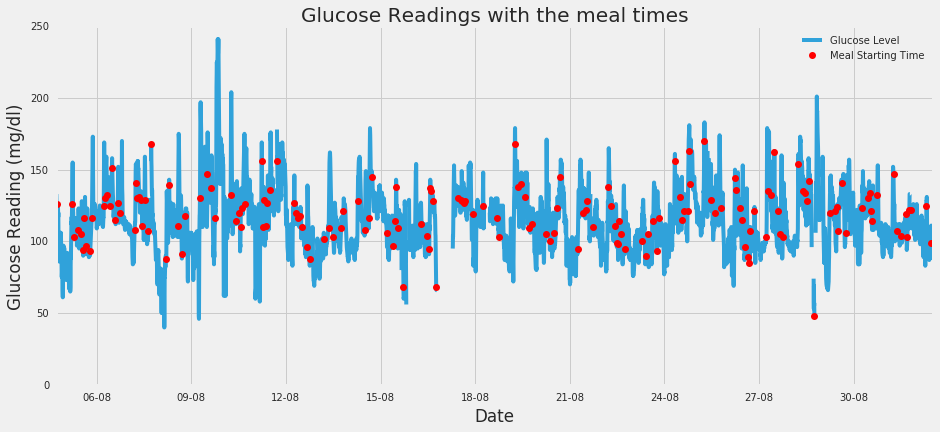

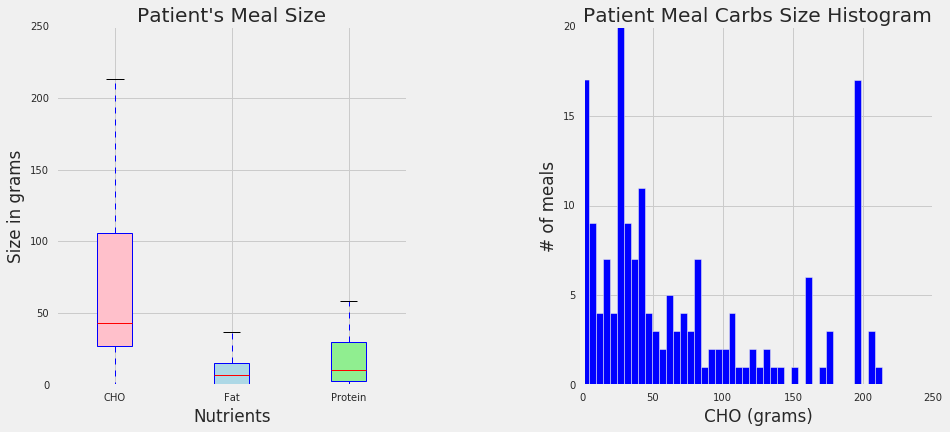



Data Cleaning...


-------------Condition 1-------------------

Remove meal data points with several missing BG readings in their postprandial window...


The meal at 2008-08-07 15:26:00 has 10 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-15 17:21:00 has 6 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-16 18:21:00 has 13 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-18 06:16:00 has 14 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-28 18:01:00 has 7 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-31 18:11:00 has 4 missing readings within its following 90 minutes. Thus, it will be removed.

There are 165 remaining meal recordings.


-------------Condition 2-------------------

Remove meal data points which do NOT have significant BG INCRE

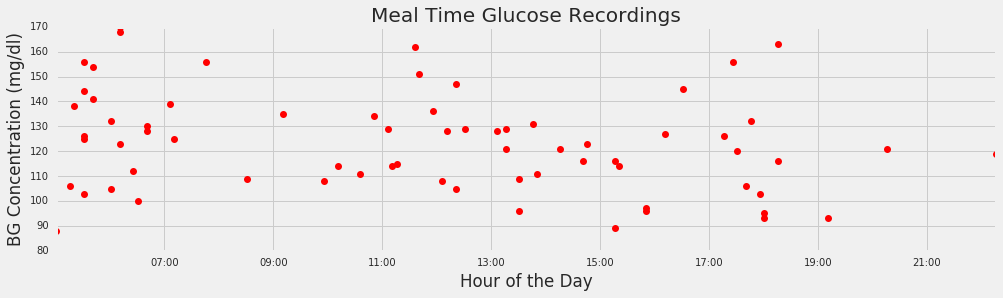

In [717]:
#Run the Data Preprocessing script first!

import warnings
warnings.filterwarnings('ignore')

#use the below couple lines to select which of the preprocessing file to use, comment the others

%run ./Data_PreProcessing_Adjusted_Mealtime.ipynb
df_P_meals_w_deletion_v3 = copy.deepcopy(increase_pts_df)

In [718]:
#Key variables for this file

least_num_signals_per_inst = 4 #Consider instances with 4 readings or more
signal_duration = 60 #signals must be longer than this duration (minutes) to be accounted for
gl_2nd_increase = 10 #second increase of 10mg/dl, the plot stops if a second increase of this value is detected (mostly happens at next meal)
after_reading = 480 #max size of the plot after meal time in minutes, i.e: up to 10 hours

# Plotting: Actual meal time recordings & Postprandial Signals & Peaks

Plot the full postprandial signal, from meal time until the next significant BG increase past the peak (mostly it is following meal).

In [719]:
#This portion of the code finds the limit of each postprandial signal
stop_plot_date = []

#for x in range(0,2):
for x in range(peak_points_df['Date'].size):#excluding the last meal
    stop = 0
    
    #need to detect when there is a significant increase between current and compared glucose levels
    current_gl_Date = peak_points_df['Date'][x]
    current_gl = df_P.loc[df_P['Date'] == current_gl_Date]['mg/dL'].values[0] 
    
    compared_gl_date = current_gl_Date

    #Here, we check if there is a second BG increase after the peak, if found => stop plot at that point
    for d in drange(0,(after_reading-peak_elapsed_time[x]), 5):
        #print "first point to compare, date:", current_gl_Date, "bg is:", current_gl
        #for l in drange(0, (after_reading-peak_elapsed_time[x]), 5):
        for l in drange(0, 45, 5):
            compared_gl_date += datetime.timedelta(minutes=incr)
            compared_gl = df_P.loc[df_P['Date'] == compared_gl_date]['mg/dL'].values[0]  
            #print "Comparison to second point, date:", compared_gl_date, "bg is:", compared_gl           
            
            #if nan, stop here
            if (math.isnan(compared_gl)):
                stop = 1
                #Need to stop the plot at this current_gl date, so let's save it
                stop_plot_date.append(compared_gl_date - datetime.timedelta(minutes=incr))
                break      
            
            if (compared_gl - current_gl > gl_2nd_increase):
                #Find lowest point between current_gl and compared_gl
                lowest2nd_pt = current_gl
                lowest2nd_pt_date = current_gl_Date
                current_gl_temp_date = current_gl_Date
                #print "Enter Loop"
                for s in drange (0,(compared_gl_date - current_gl_Date).seconds / 60,5):
                    current_gl_temp_date += datetime.timedelta(minutes=incr)
                    current_gl_temp = df_P.loc[df_P['Date'] == current_gl_temp_date]['mg/dL'].values[0]
                    #print "current is: date", current_gl_temp_date, "bg is:", current_gl_temp
                    #print "lowest 2n is: date", lowest2nd_pt_date, "bg is:", lowest2nd_pt
                    if (current_gl_temp <= lowest2nd_pt):
                        lowest2nd_pt = current_gl_temp
                        lowest2nd_pt_date = current_gl_temp_date
                stop = 1
                #Need to stop the plot at this current_gl date, so let's save it
                stop_plot_date.append(lowest2nd_pt_date)
                break
        if (stop == 1):
            #print "Stop here", current_gl_Date
            #print "meal,", x
            break
        current_gl_Date += datetime.timedelta(minutes=incr)    
        current_gl = df_P.loc[df_P['Date'] == current_gl_Date]['mg/dL'].values[0] 
    
        compared_gl_date = current_gl_Date    
            
        if (d == after_reading-peak_elapsed_time[x]):
            #print "All the way"
            stop_plot_date.append(current_gl_Date)
            #print "meal,", x

stop_plot_bg_list = [] 

for k in range(len(stop_plot_date)):            
    stop_plot_bg = df_P.loc[df_P['Date'] == stop_plot_date[k]]['mg/dL'].values[0]
    stop_plot_bg_list.append(stop_plot_bg)
#print stop_plot_bg_list


#removing last meal info since it may not have a long enough postprandial signal
#df_P_meals_w_deletion_v3.drop(df_P_meals_w_deletion_v3.index[-1], axis=0,inplace=True)
#print df_P_meals_w_deletion_v3['Date'].size
#print len(stop_plot_date)


The cell above derives the stop points of postprandial signals of all the meals. The stop points are stored in: stop_plot_date 

The cell below creates a dataframe that contains all the points of the postprandial signals for all the meals, from meal time to stop point. The dataframe is: df_all_plots_v2 

In [720]:
Plot_window = [i for i in np.arange(0, after_reading+incr, incr)]

def Plot_extraction_v2(df_P1_w_all_deletion, df_all_plots_v2):
    #print "size is", df_P1_w_all_deletion['Date'].size
    #print "stop plot size is ", len(stop_plot_date)
    for x in range(df_P1_w_all_deletion['Date'].size):
        nancount = 0 #if there are nan readings, stop at the first one
        a = df_P1_w_all_deletion['Date'][x]
        
        #Check if it's last reading, do not consider last meal
        if (x<(df_P1_w_all_deletion['CHO (g)'].size)):              
            b = a
            reading_list = []
            for j in Plot_window:
                reading = df_P.loc[df_P ['Date'] == b]['mg/dL']
                c = stop_plot_date[x]  #Stop at this date because there is another glucose increase right after it       
                try:
                    reading.values[0]
                except IndexError:
                    #print "Index out of range"
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue

                if (((c - b).total_seconds() < 0)) : 
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue
                else:
                    #store this value on the jth column of xth row of the new dataframe
                    reading_list.append(reading.values[0])
                    b += datetime.timedelta(minutes=incr)
        #print reading_list
        df_all_plots_v2.loc[x]=reading_list
    
    ##If the postprandial signal has many missing points within it, in the middle, remove it
    
    print "Total meals to be plotted are:", df_all_plots_v2.shape[0], "\n"

In [721]:
stop_pt = []
for k in range(len(stop_plot_date)):
    stop_pt.append(((stop_plot_date[k] - df_P_meals_w_deletion_v3['Date'][k]).seconds)/60)

def plotting(df_all_plots_v2, df_P1_w_all_deletion):
    first = True
    plt.figure(figsize=(20,12))
    #for j in range(0,1):
    for j in range(len(df_all_plots_v2)):
        #print df_all_plots_v2.iloc[j]
        #print df_P1_w_all_deletion.iloc[j]
        
        #print peak_points_df['mg/dL'][j]
        row = df_all_plots_v2.iloc[j]
 
        if (first==True):
            #Recorded meal time reading
            plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=12, label ='Meal Recordings')
            #Lowest surrounding point of increase
            plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=15, label ='Glucose Peaks')
            first = False
            row.plot(label='Meal Time Carbs {} g'.format(round((df_P1_w_all_deletion['CHO (g)'][j]),2)))
            continue
        
        row.plot(label='Meal Time Carbs {} g'.format(round((df_P1_w_all_deletion['CHO (g)'][j]),2)))
        plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=12)
        plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=15)            
        
        #plt.plot(stop_pt[j], stop_plot_bg_list[j], 'b*', markersize=15)
 

    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Post-meal BG variation of Different Meals'.format(after_reading)
    plt.title(title);

    #Uncomment below to save plot
    #plt.savefig('Patient_1_Plotsaftermeal_iter0to5.png')

Total meals to be plotted are: 69 



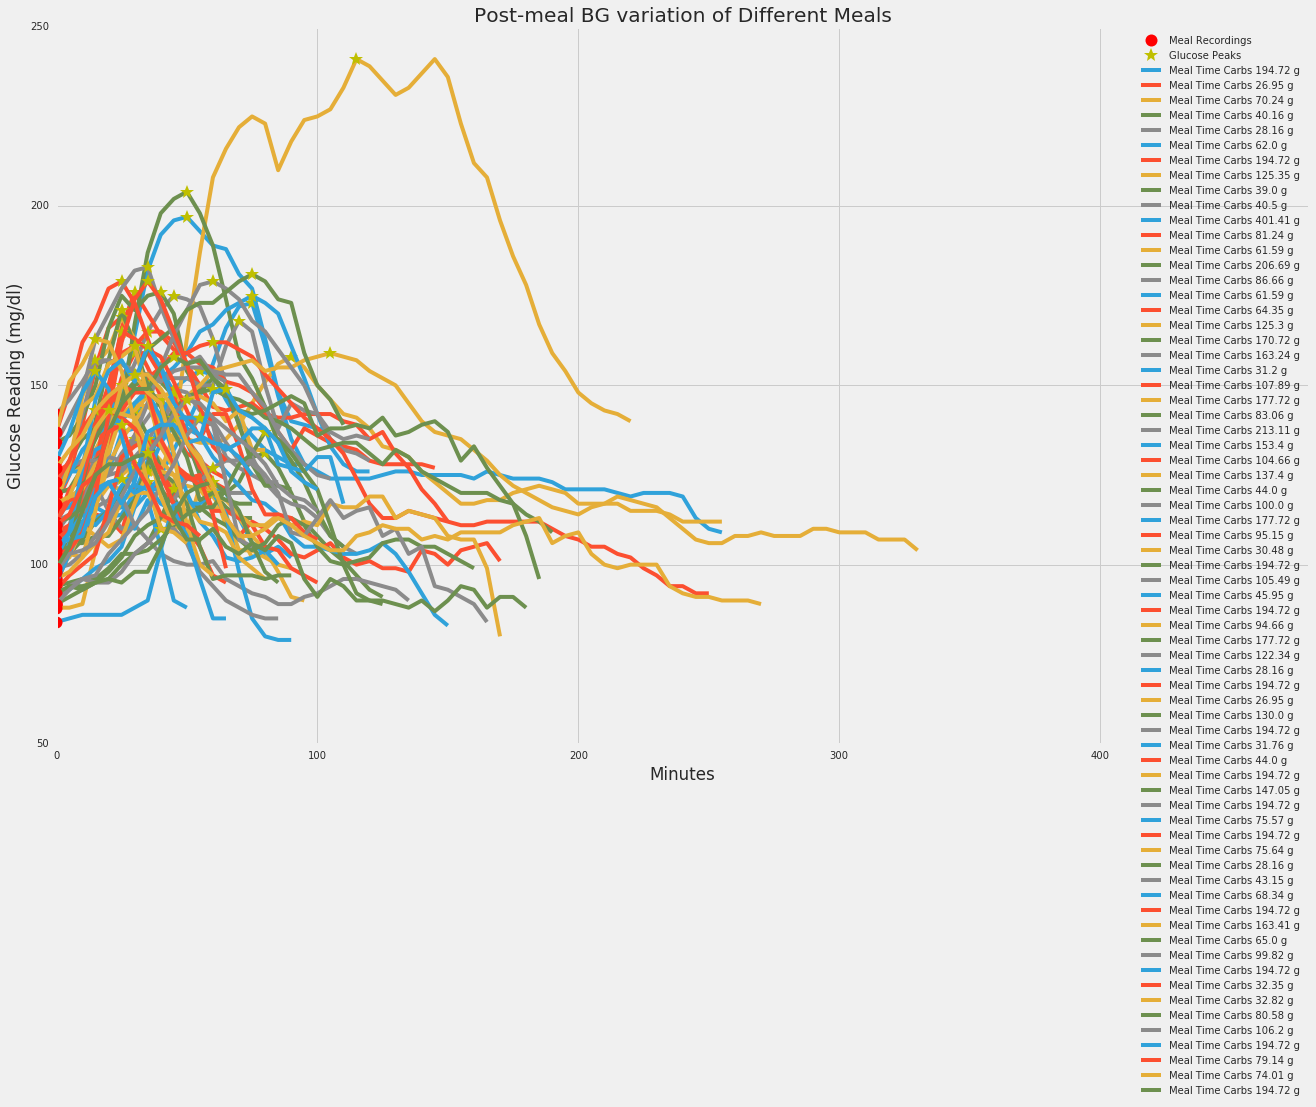

In [722]:
df_all_plots_v2 = pd.DataFrame(columns=Plot_window)

#df_all_plots_v2: contains the full postprandial signals for all meals
#df_P_meals_w_deletion_v3: contains the meal time readings and their info

Plot_extraction_v2(df_P_meals_w_deletion_v3, df_all_plots_v2)
plotting(df_all_plots_v2, df_P_meals_w_deletion_v3)

#print "size of df containing meals is:", df_P_meals_w_deletion_v3.shape[0]
#print "size of df containing plots of all meals is:", df_all_plots_v2.shape[0]

### Remove plots which have a duration less than 60 minutes

In [723]:
#print_full(all_signals_df_cleaned)
#print all_signals_df_cleaned.shape[0]

print df_all_plots_v2.shape[0]

def remove_short_signals(period_signals):
    #Detect first NaN occurance on the signal, if less than 90 minutes remove that signal
    global signal_incomplete
    signal_incomplete = []
    for j in range(period_signals.shape[0]):
        #print "j is:", j 
        #print period_signals.iloc[j]
        out = np.argwhere(np.isnan(period_signals.iloc[j]))
        try:
            out[0][0]
        except IndexError:
            #print "full signal, no NAN"   
            continue   
        #print out[0][0]
        #print "j is:", out[0]
        if ((out[0][0]*5) < signal_duration): #if signal is less than 90 minutes
            signal_incomplete.extend([j])

remove_short_signals(df_all_plots_v2)  

#print signal_incomplete  
print len(signal_incomplete), "signals are removed from all postprandial signals.\n"
df_all_plots_v2.drop(df_all_plots_v2.index[signal_incomplete], axis=0,inplace=True)
df_all_plots_v2 = df_all_plots_v2.reset_index(drop=True)

print "Total remaining meals are:", df_all_plots_v2.shape[0]


69
7 signals are removed from all postprandial signals.

Total remaining meals are: 62


### Remove those signals from other dataframes and series as well

In [724]:
# print peak_elapsed_time.size
# print peak_points_df.shape[0]
# print df_P_meals_w_deletion_v3.shape[0]

peak_elapsed_time = np.delete(peak_elapsed_time, signal_incomplete, axis=0)

peak_points_df.drop(peak_points_df.index[signal_incomplete], axis=0,inplace=True)
peak_points_df = peak_points_df.reset_index(drop=True)

df_P_meals_w_deletion_v3.drop(df_P_meals_w_deletion_v3.index[signal_incomplete], axis=0,inplace=True)
df_P_meals_w_deletion_v3 = df_P_meals_w_deletion_v3.reset_index(drop=True)

# print peak_elapsed_time.size
# print peak_points_df.shape[0]
# print df_P_meals_w_deletion_v3.shape[0]

### Distribution of the peak elapsed time duration and BG increase between meal and peak.

The average duration between the meal and peak is: 45.0 minutes with a std of 21.0 minutes.


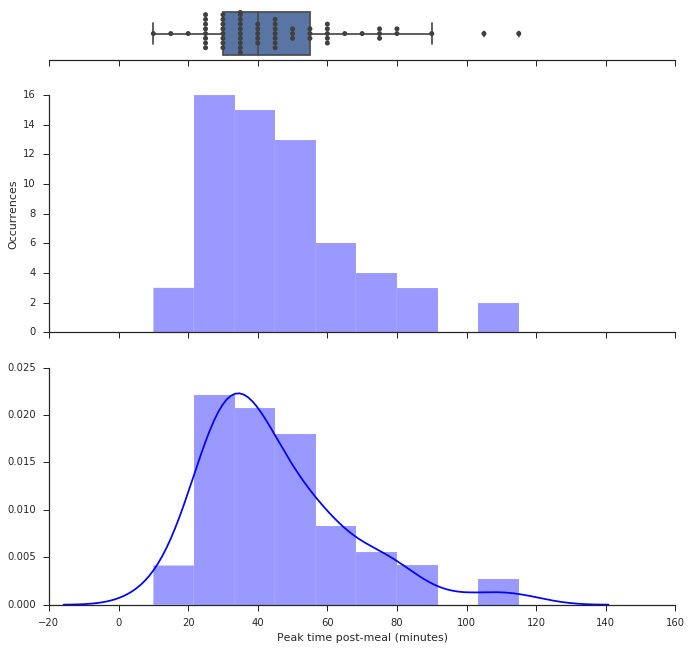

In [745]:
#Skip if you do not have seaborn library installed or install it


print "The average duration between the meal and peak is:", round(np.mean(peak_elapsed_time),0), "minutes with a std of", round(np.std(peak_elapsed_time),0), "minutes."

peak_measure = 1


def signal_distr(signal_content, peak_measure):

    
    import seaborn as sns

    sns.set(style="ticks")

    f, (ax_box, ax_hist1, ax_hist2) = plt.subplots(3, sharex=True, 
                                        gridspec_kw={"height_ratios": (.10, .45, .45)}, figsize=(10,10))

    b = sns.boxplot(signal_content, ax=ax_box)
    sns.swarmplot(signal_content, ax=ax_box, color=".25")
    if (peak_measure == 1):
        bin_size = len(signal_content)/ 5
    else:
        bin_size = len(signal_content)/ 3       
    h1 = sns.distplot( signal_content, ax=ax_hist1, bins=bin_size, kde=False, color='b')
    h2 = sns.distplot( signal_content, ax=ax_hist2, bins=bin_size, kde=True, color='b')

    h1.set(xlabel='', ylabel='Occurrences')
    if (peak_measure == 1):
        h2.set(xlabel='Peak time post-meal (minutes)', ylabel='')
    elif (peak_measure == 2):
        h2.set(xlabel='BG Difference (mg/dl)', ylabel='')        
    else:
        h2.set(xlabel='Meal Carbs (grams)', ylabel='')
    # Y axis in h2 is unitless measurement but any mesaurable area under the curve can be interpreted as a probability estimate.
    b.set(xlabel='')

    ax_box.set( yticks=[])
    sns.despine(ax=ax_hist1)
    sns.despine(ax=ax_hist2)
    sns.despine(ax=ax_box, left=True)

    #reset to original plotting format, instead of seaborn

    sns.reset_orig()

signal_distr(peak_elapsed_time, peak_measure)



### Distribution of BG difference between peak and BG Increase points concentrations

Mean of BG difference between meal and postprandial peak is: 44.5 mg/dl, with a std of 18.8 mg/dl.


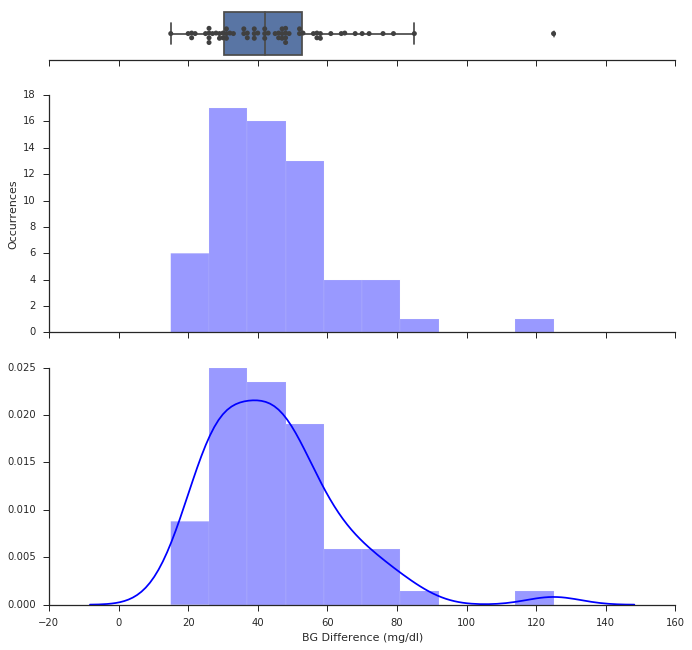

In [746]:
#Skip if you do not have seaborn library installed or install it

Peak_difference = []

peak_measure = 2

for x in range(peak_points_df['Date'].size):
    meal_gl = df_P_meals_w_deletion_v3['mg/dL'][x]
    peak_gl = peak_points_df['mg/dL'][x]
        
    #print "Meal BG is:", meal_gl, "at", df_P_meals_w_deletion_v3['Date'][x]
    #print "peak BG is:", peak_gl, "at", peak_points_df['Date'][x]
    
    difference_gl = peak_gl - meal_gl
    
    Peak_difference.append(difference_gl)

print "Mean of BG difference between meal and postprandial peak is:", round(np.mean(Peak_difference),1), "mg/dl, with a std of", round(np.std(Peak_difference),1), "mg/dl."    

#Visualizing the distribution of BG differences between the meal and peak

signal_distr(Peak_difference, peak_measure)

## Alignment and Normalization Methods of the signals

L-2 Normalization: It normalizes the signal by dividing each element over the sqrt(sum(x^2)), so the sum of elements of the normalized row equal to 1.

In [747]:
from sklearn import preprocessing

def alignmentandnormalization(df_period_plots):

    global signals_normalized_df 
    signals_normalized_df = copy.deepcopy(df_period_plots)
    global signals_aligned_df 
    signals_aligned_df = copy.deepcopy(df_period_plots)
    
    signalsdf_wo_nan = pd.DataFrame()

   
    for j in range(len(df_period_plots)):
    #signalsdf_wo_nan[j] = df_all_plots_v2.iloc[j][~np.isnan(df_all_plots_v2.iloc[j])]

        signal_wo_nan = df_period_plots.iloc[j][~np.isnan(df_period_plots.iloc[j])]
        aligned_signal = [x - df_period_plots.iloc[j,0] for x in signal_wo_nan]

        #with alignment and without
        normalized_signal = preprocessing.normalize(aligned_signal, norm='l2')#with alignment of signals  
        #normalized_signal = preprocessing.normalize(signal_wo_nan, norm='l2')#without alignment

        signals_aligned_df.iloc[j,0:len(aligned_signal)] = aligned_signal 
        signals_aligned_df.iloc[j,len(aligned_signal):df_period_plots.shape[1]] = np.nan

        signals_normalized_df.iloc[j,0:normalized_signal.size] = normalized_signal 
        signals_normalized_df.iloc[j,normalized_signal.size:df_period_plots.shape[1]] = np.nan
    
    #print "size of signals_normalized_df", len(signals_normalized_df)
    
#print normalized_signal[:]
#print signals_normalized_df

#print df_normalized

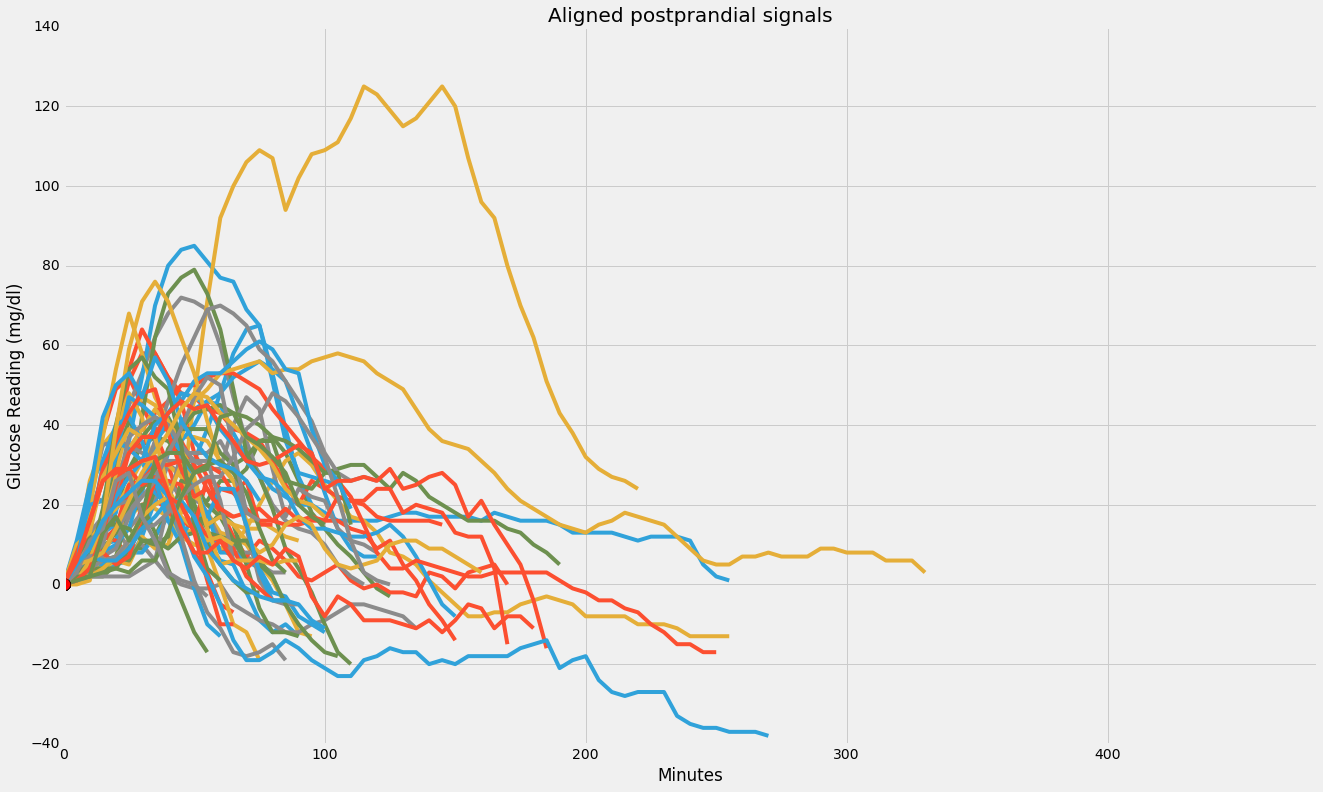

In [748]:
#alignmentandnormalization(df_all_plots_v2)
import warnings
warnings.filterwarnings('ignore') 

def plotsaligned(periodmeals, full_postprandials):
    #print "\nPostprandial signals aligned...\n"
    
    alignmentandnormalization(full_postprandials)
    
    plt.figure(figsize=(20,12))

    #for j in range(1,20):
    for j in range(len(signals_aligned_df)):
        #print df_all_plots_v2.iloc[j]
        row = signals_aligned_df.iloc[j]
        #if (round((df_P_meals_w_deletion_v3['CHO (g)'][j]),2) < 35):
        row.plot(label = '')
        #row.plot(label='Meal Time Carbs {} g'.format(round((periodmeals['CHO (g)'][j]),2)))
        plt.plot(0, signals_aligned_df[0][j], 'ro', markersize=12)     


    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Aligned postprandial signals'
    plt.title(title);
    
plotsaligned(df_P_meals_w_deletion_v3, df_all_plots_v2)   

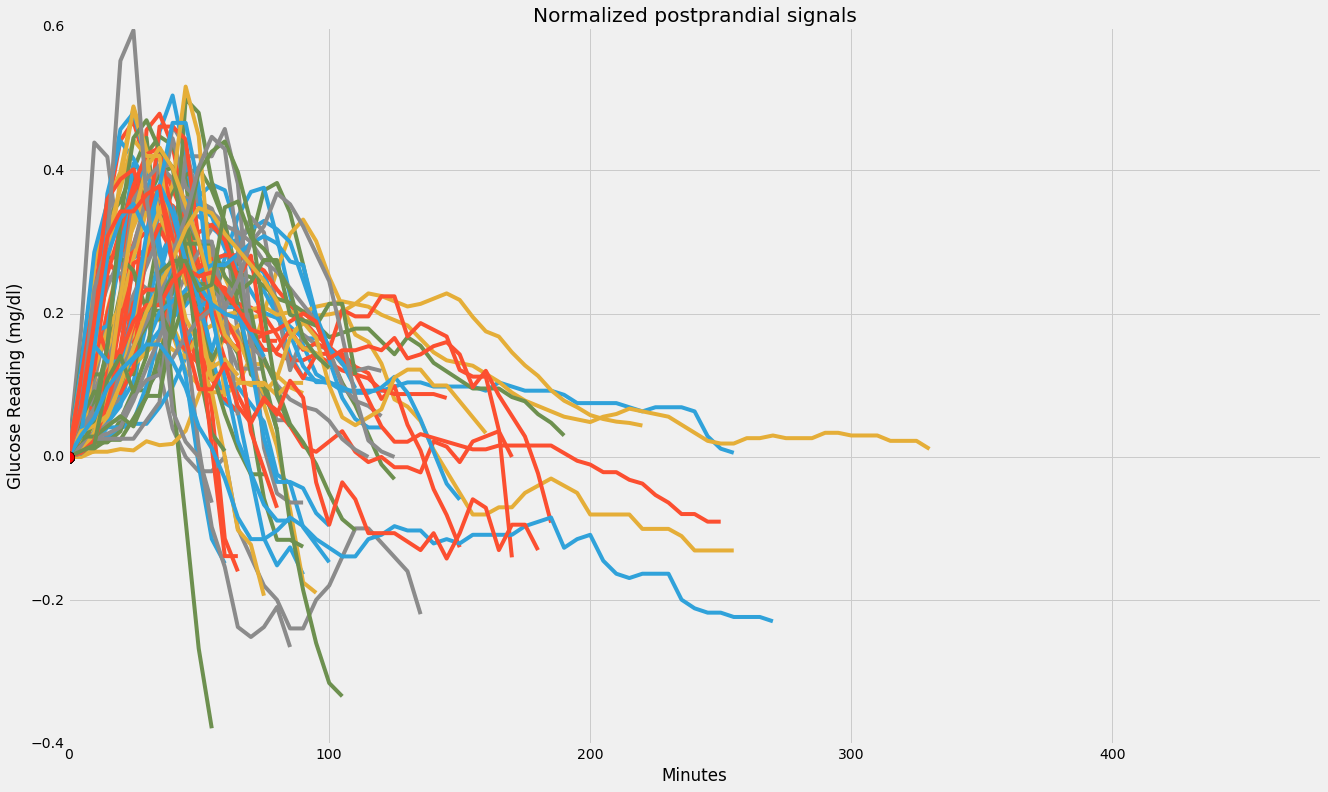

In [749]:
def plotsnormalized(periodmeals, full_postprandials):
    #print "\nPostprandial signals aligned and normalized...\n"
    alignmentandnormalization(full_postprandials)
    
    plt.figure(figsize=(20,12))
    #print "size of current df is:", len(signals_normalized_df)
    #print_full(signals_normalized_df)
      
    #for j in range(11,20):
    for j in range(len(signals_normalized_df)):
        #print df_all_plots_v2.iloc[j]
        row = signals_normalized_df.iloc[j]
        #print "pritning value of", j,"signal:", (round((periodmeals['CHO (g)'][j]),2))
        row.plot(label ='')
        #row.plot(label='Meal Time Carbs {} g'.format(round((periodmeals['CHO (g)'][j]),2)))
        plt.plot(0, signals_normalized_df[0][j], 'ro', markersize=12)     


    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Normalized postprandial signals'
    plt.title(title);

#output_df = pd.DataFrame    
plotsnormalized(df_P_meals_w_deletion_v3, df_all_plots_v2)
#output_df = copy.deepcopy(signals_normalized_df)
#print_full(output_df)


**Normalization is not recommended because it removes the BG difference between various signals**

## Dividing the day into Breakfast, Lunch, Dinner

In [750]:
df_all_clean_1day = copy.deepcopy(df_P_meals_w_deletion_v3)#actual meals, and not the increase points

d = datetime.datetime.today()
for i in range(len(df_all_clean_1day)):
    dt = df_all_clean_1day.Date[i].replace(year=d.year, month=d.month, day=d.day)    
    df_all_clean_1day.Date[i] = dt

#output to static HTML file
output_file("Aggregated_Meal_Recordings.html")

plot = figure(plot_width=1250, plot_height=600, title="Meal Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

good_readings = ColumnDataSource(dict(x=df_all_clean_1day.Date, y=df_all_clean_1day['mg/dL'], z=df_all_clean_1day['CHO (g)'], k = df_all_clean_1day['Fat (g)'], d = df_all_clean_1day['Protein (g)']))

g1 = plot.asterisk(x=df_all_clean_1day.Date, y=df_all_clean_1day['mg/dL'], line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Hour of the Day"
plot.yaxis.axis_label = "BG Concentration (mg/dL)"

show(plot)

In [751]:
#The three main data sets are below:

All_periods_df = copy.deepcopy(df_all_plots_v2)
breakfast_df = copy.deepcopy(df_all_plots_v2)
lunch_df = copy.deepcopy(df_all_plots_v2)
dinner_df = copy.deepcopy(df_all_plots_v2)

peak_elapsed_breakfast = copy.deepcopy(peak_elapsed_time)
peak_elapsed_lunch = copy.deepcopy(peak_elapsed_time)
peak_elapsed_dinner = copy.deepcopy(peak_elapsed_time)

breakfast_peak_df = copy.deepcopy(peak_points_df)
lunch_peak_df = copy.deepcopy(peak_points_df)
dinner_peak_df = copy.deepcopy(peak_points_df)

breakfast_start_hour = 5
breakfast_max_hour = 10

lunch_start_hour = 11
lunch_max_hour = 15

#snack_start_hour = 14
#snack_max_hour = 16

dinner_start_hour = 17
dinner_max_hour = 23

remove_from_breakfast_x = []
remove_from_lunch_x = []
remove_from_dinner_x = []

keep_breakfast_x = []
keep_lunch_x = []
keep_dinner_x =[]
keep_x = []

for x in range(len(df_P_meals_w_deletion_v3)):
    a = df_P_meals_w_deletion_v3['Date'][x]
    meal_Date = df_P.loc[df_P['Date'] == a]['Date']
    meal_dt=meal_Date.values[0]
    mdt = datetime.datetime.utcfromtimestamp(meal_dt.astype('O')/(1e9))
    #print mdt.strftime('%H:%M:%S')
    meal_hr = mdt.strftime('%H')    
    #print int(meal_hr)
    if (int(meal_hr)>breakfast_max_hour or int(meal_hr)<breakfast_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period
        remove_from_breakfast_x.append(x)
    else:    
        keep_breakfast_x.append(x)
        
    if (int(meal_hr)>lunch_max_hour or int(meal_hr)<lunch_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period  
        remove_from_lunch_x.append(x)
    else:    
        keep_lunch_x.append(x)
    
    if (int(meal_hr)>dinner_max_hour or int(meal_hr)<dinner_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period
        remove_from_dinner_x.append(x)
    else:    
        keep_dinner_x.append(x)
    
    keep_x.append(x)
#print remove_from_breakfast_x
#print keep_breakfast_x
        
###############Breakfast
breakfast_df.drop(breakfast_df.index[remove_from_breakfast_x],axis=0,inplace=True)
breakfast_df = breakfast_df.reset_index(drop=True)  
print "This patient has", len(breakfast_df), "breakfast readings.\n"
#print "The indeces of breakfast within the full dataframe are:", keep_breakfast_x

breakfast_peak_df.drop(breakfast_peak_df.index[remove_from_breakfast_x],axis=0,inplace=True)
breakfast_peak_df = breakfast_peak_df.reset_index(drop=True)

peak_elapsed_breakfast = np.delete(peak_elapsed_breakfast, remove_from_breakfast_x)

###############Lunch
lunch_df.drop(lunch_df.index[remove_from_lunch_x],axis=0,inplace=True)
lunch_df = lunch_df.reset_index(drop=True)  
print "This patient has", len(lunch_df), "lunch readings.\n"
#print "The indeces of lunch within the full dataframe are:", keep_lunch_x


lunch_peak_df.drop(lunch_peak_df.index[remove_from_lunch_x],axis=0,inplace=True)
lunch_peak_df = lunch_peak_df.reset_index(drop=True)

peak_elapsed_lunch = np.delete(peak_elapsed_lunch, remove_from_lunch_x)


###############Dinner
dinner_df.drop(dinner_df.index[remove_from_dinner_x],axis=0,inplace=True)
dinner_df = dinner_df.reset_index(drop=True) 
print "This patient has", len(dinner_df), "dinner readings.\n"
#print "The indeces of dinner within the full dataframe are:", keep_dinner_x

dinner_peak_df.drop(dinner_peak_df.index[remove_from_dinner_x],axis=0,inplace=True)
dinner_peak_df = dinner_peak_df.reset_index(drop=True)

peak_elapsed_dinner = np.delete(peak_elapsed_dinner, remove_from_dinner_x)
    
#dinner_df.to_csv('Patient1_dinner_df.csv', sep='\t', encoding='utf-8')
#dinner_df.to_csv('Patient_dinner_df.csv', index=False)
#lunch_df.to_csv('Patient_lunch_df.csv', index=False)
#breakfast_df.to_csv('Patient_breakfast_df.csv', index=False)
    
all_breakfast_df = pd.DataFrame()
all_lunch_df = pd.DataFrame() 
all_dinner_df = pd.DataFrame()
all_combined_df = pd.DataFrame()

def period_meals_list(kept_period_meals):
    df_period_meals = pd.DataFrame()
    for k in range(len(kept_period_meals)):
        df_period_meals[k] = df_P_meals_w_deletion_v3.iloc[kept_period_meals[k]]    
    
    meals_df = copy.deepcopy(df_period_meals.T)
    #print  meals_df
    return meals_df

#print "This patient has the recorded the following meals for breakfast:"
all_breakfast_df = period_meals_list(keep_breakfast_x)

#print all_breakfast_df

#print "This patient has the recorded the following meals for lunch:"
all_lunch_df = period_meals_list(keep_lunch_x)

#print "This patient has the recorded the following meals for dinner:"
all_dinner_df = period_meals_list(keep_dinner_x)

all_combined_df = period_meals_list(keep_x)
#print all_combined_df

This patient has 23 breakfast readings.

This patient has 23 lunch readings.

This patient has 13 dinner readings.



## Visualizing breakfast meals Carbs...

[194.72, 26.95, 194.72, 125.35, 401.41, 206.69, 61.59, 170.72, 163.24, 177.72, 104.66, 137.4, 194.72, 194.72, 177.72, 194.72, 26.95, 194.72, 194.72, 194.72, 194.72, 194.72, 194.72] 

Mean of BG difference between meal and post-breakfast peak is: 170.5 mg/dl, with a std of 72.8 mg/dl.


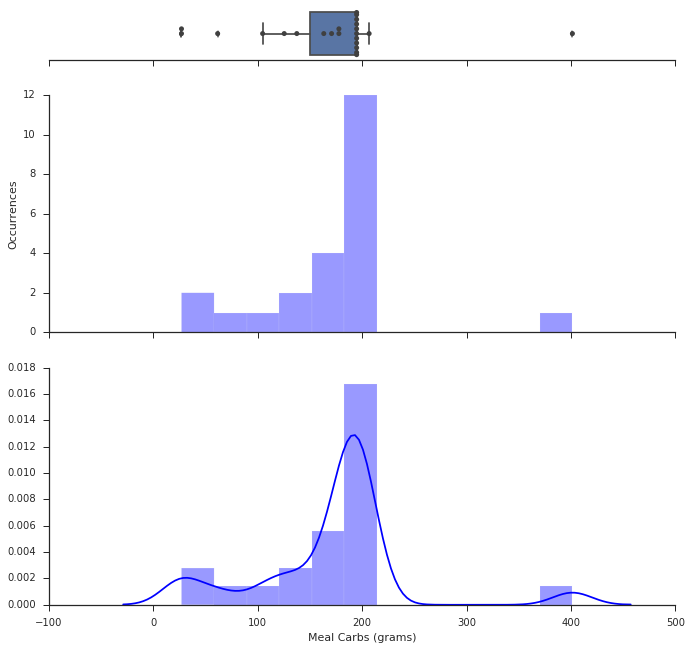

In [752]:
peak_measure = 3

def get_prandial_arr(period_df):
    global signal_arr
    signal_arr = period_df['CHO (g)'].values
    signal_arr = [ round(x,2) for x in signal_arr]
    print signal_arr, "\n"

#print "Visualizing breakfast meals...\n"

if (all_breakfast_df.shape[0] > least_num_signals_per_inst):
    get_prandial_arr(all_breakfast_df)
    print "Mean of BG difference between meal and post-breakfast peak is:", round(np.mean(signal_arr),1), "mg/dl, with a std of", round(np.std(signal_arr),1), "mg/dl."    
    signal_distr(signal_arr, peak_measure)
    
else:
    print "There are not enough meals within this prandial period to analyze!"


## Visualizing lunch meals Carbs...

[70.24, 40.16, 39.0, 81.24, 86.66, 64.35, 31.2, 83.06, 153.4, 44.0, 100.0, 95.15, 30.48, 105.49, 94.66, 28.16, 31.76, 75.64, 28.16, 43.15, 65.0, 80.58, 79.14] 

Mean of BG difference between meal and post-lunch peak is: 67.4 mg/dl, with a std of 31.2 mg/dl.


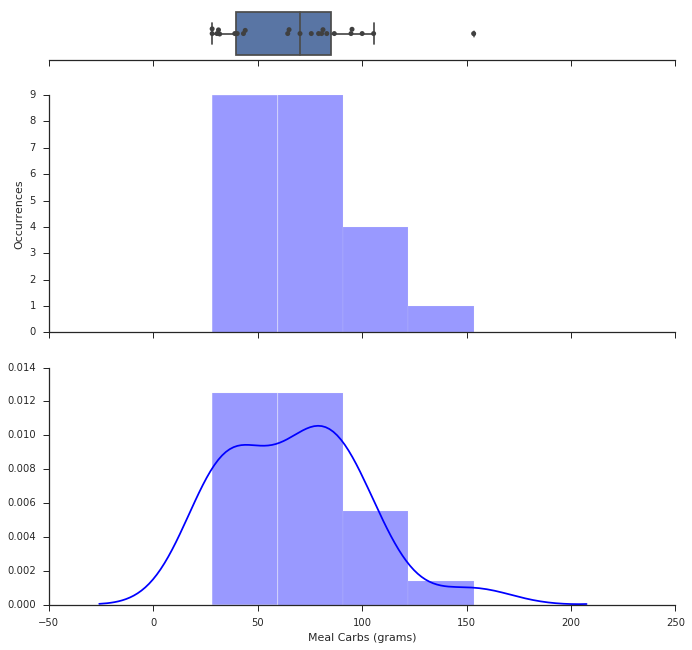

In [753]:
#print "Visualizing lunch meals...\n"    

if (all_lunch_df.shape[0] > least_num_signals_per_inst):
    get_prandial_arr(all_lunch_df)
    print "Mean of BG difference between meal and post-lunch peak is:", round(np.mean(signal_arr),1), "mg/dl, with a std of", round(np.std(signal_arr),1), "mg/dl."    
    signal_distr(signal_arr, peak_measure)
    
else:
    print "There are not enough meals within this prandial period to analyze!"



## Visualizing dinner meals Carbs...

Visualizing dinner meals...

[62.0, 40.5, 125.3, 107.89, 213.11, 45.95, 130.0, 44.0, 147.05, 68.34, 99.82, 106.2, 74.01] 

Mean of BG difference between meal and post-dinner peak is: 97.2 mg/dl, with a std of 47.4 mg/dl.


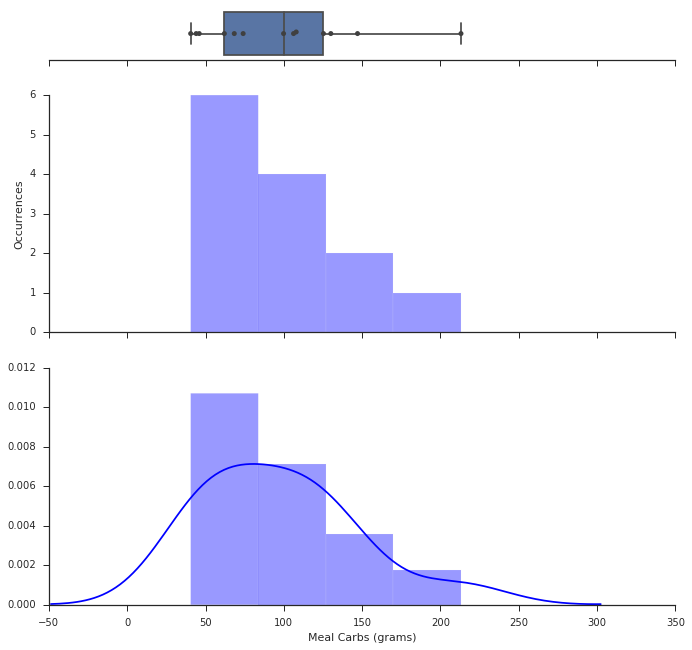

In [754]:
print "Visualizing dinner meals...\n"    

if (all_dinner_df.shape[0] > least_num_signals_per_inst):
    get_prandial_arr(all_dinner_df)
    print "Mean of BG difference between meal and post-dinner peak is:", round(np.mean(signal_arr),1), "mg/dl, with a std of", round(np.std(signal_arr),1), "mg/dl."    
    signal_distr(signal_arr, peak_measure)
    
else:
    print "There are not enough meals within this prandial period to analyze!"



In [755]:
def Plot_Period(period_to_plot, peaks_df, peaks_offset):

    period_df = copy.deepcopy(period_to_plot)
    peak_pts_df = copy.deepcopy(peaks_df)
    peak_elapsed_t = copy.deepcopy(peaks_offset)
    
    plt.figure(figsize=(20,12))
    #for j in range(0,5):
    for j in range(len(period_df)):
        row = period_df.iloc[j]
        row.plot()
        #row.plot(label='Meal Time at {}'.format(df_P1_w_all_deletion['Date'][j]))
        #Recorded meal time reading
        plt.plot(0, period_df[0][j], 'ro', markersize=10)
        plt.plot(peak_elapsed_t[j], peak_pts_df['mg/dL'][j], 'y*', markersize=20) 

    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    #plt.legend(loc='upper right')
    title = 'Glucose Lelvel Readings {} minutes after meal recording or until next meal recording'.format(after_reading)
    plt.title(title)

    plt.show()

Plotting of segmented after meal plots for Breakfast


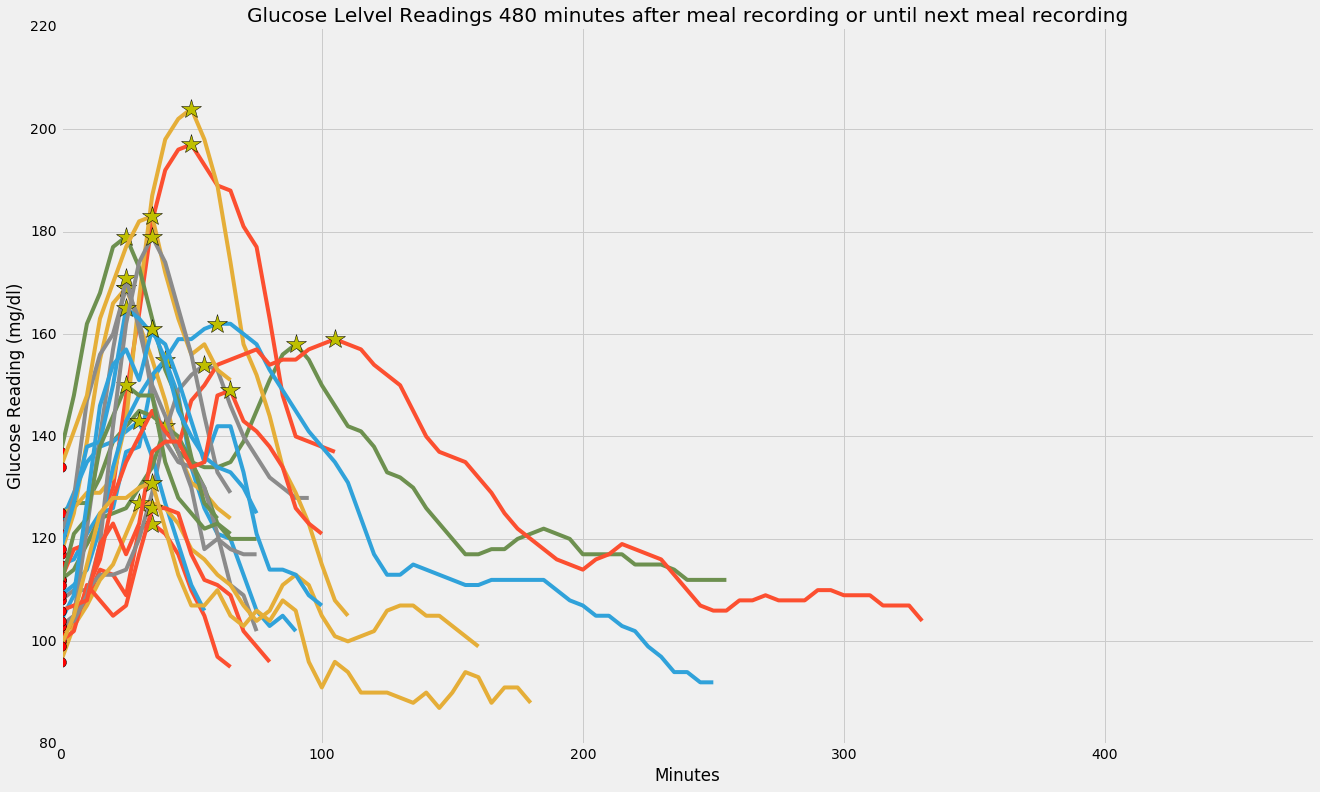

Plotting of segmented after meal plots for Lunch


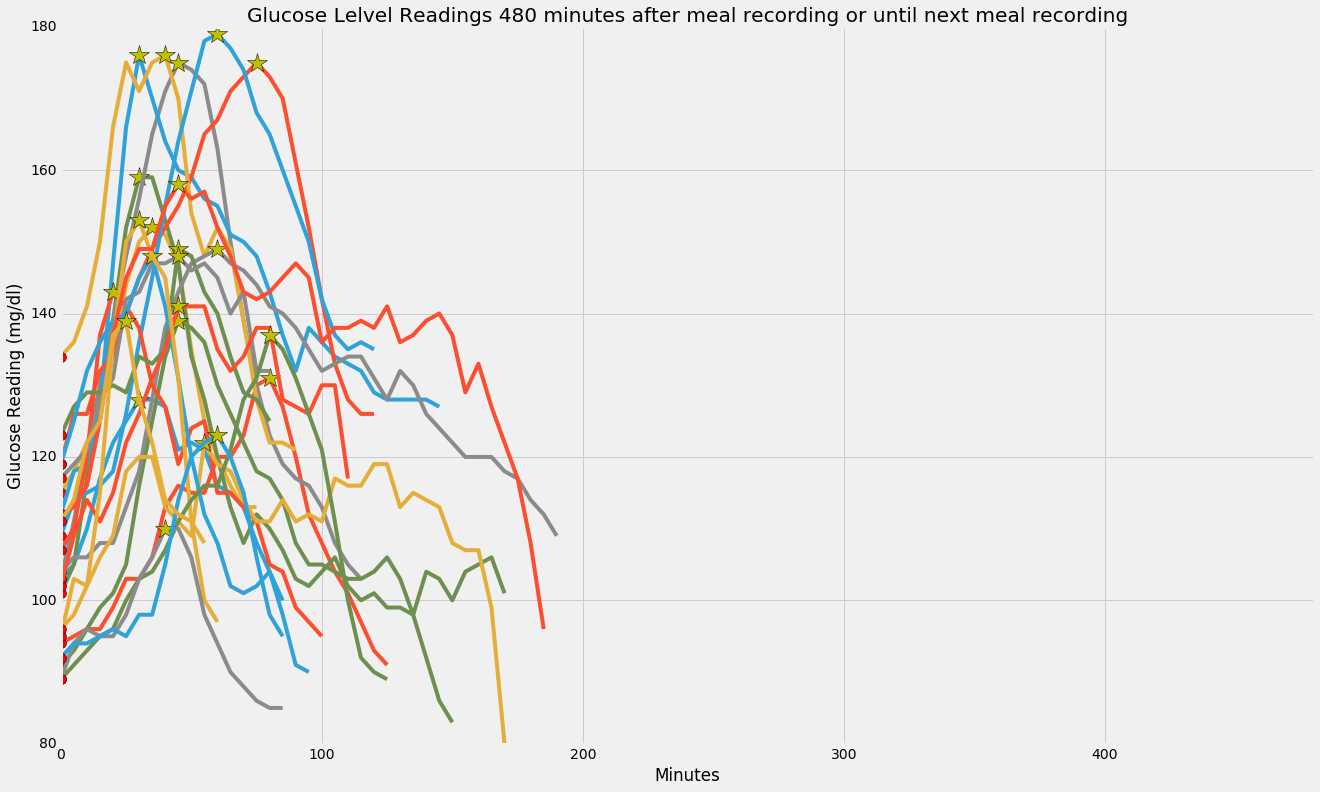

Plotting of segmented after meal plots for Dinner


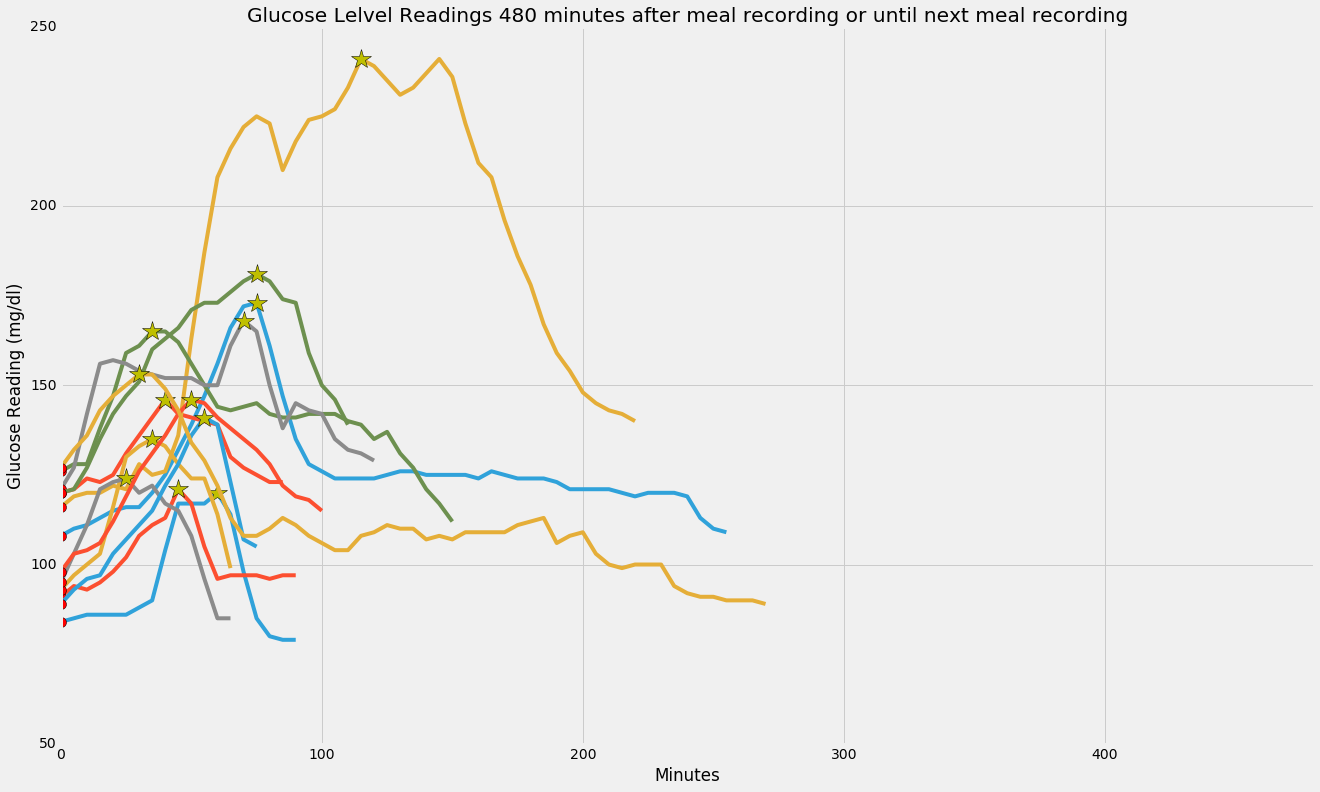

In [756]:
#Plot any preriod by replacing period_df by the desired period,
#arg1 is breakfast_df or lunch_df or dinner_df
#arg2 is breakfast_peak_df, lunch_peak_df, dinner_peak_df
#arg3 is peak_elapsed_breakfast, peak_elapsed_lunch, peak_elapsed_dinner

print "Plotting of segmented after meal plots for Breakfast"
Plot_Period(breakfast_df, breakfast_peak_df, peak_elapsed_breakfast)

print "Plotting of segmented after meal plots for Lunch"
Plot_Period(lunch_df, lunch_peak_df, peak_elapsed_lunch)

print "Plotting of segmented after meal plots for Dinner"
Plot_Period(dinner_df, dinner_peak_df, peak_elapsed_dinner)




**Plotting aligned plots for each period respectively**


Plotting aligned postprandial signals for breakfast, lunch, dinner, respectively...


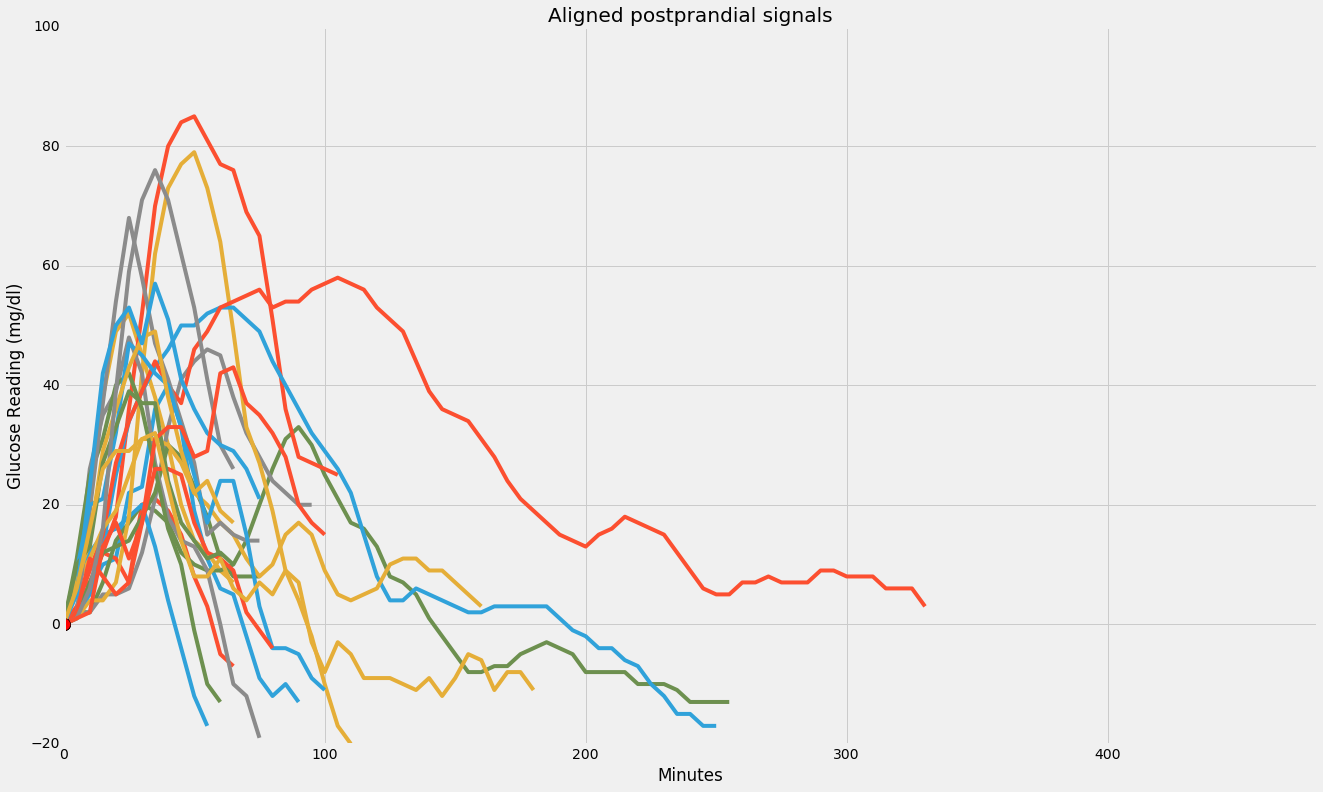

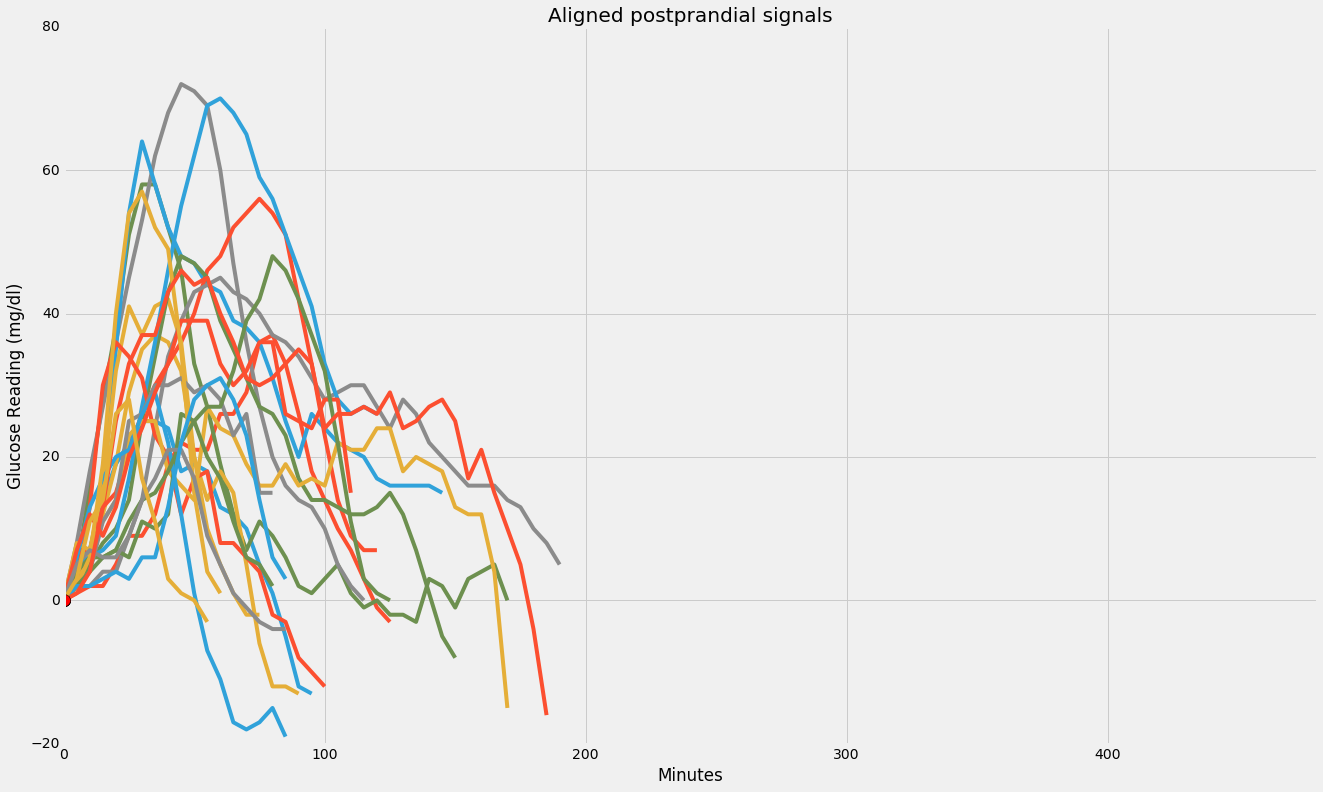

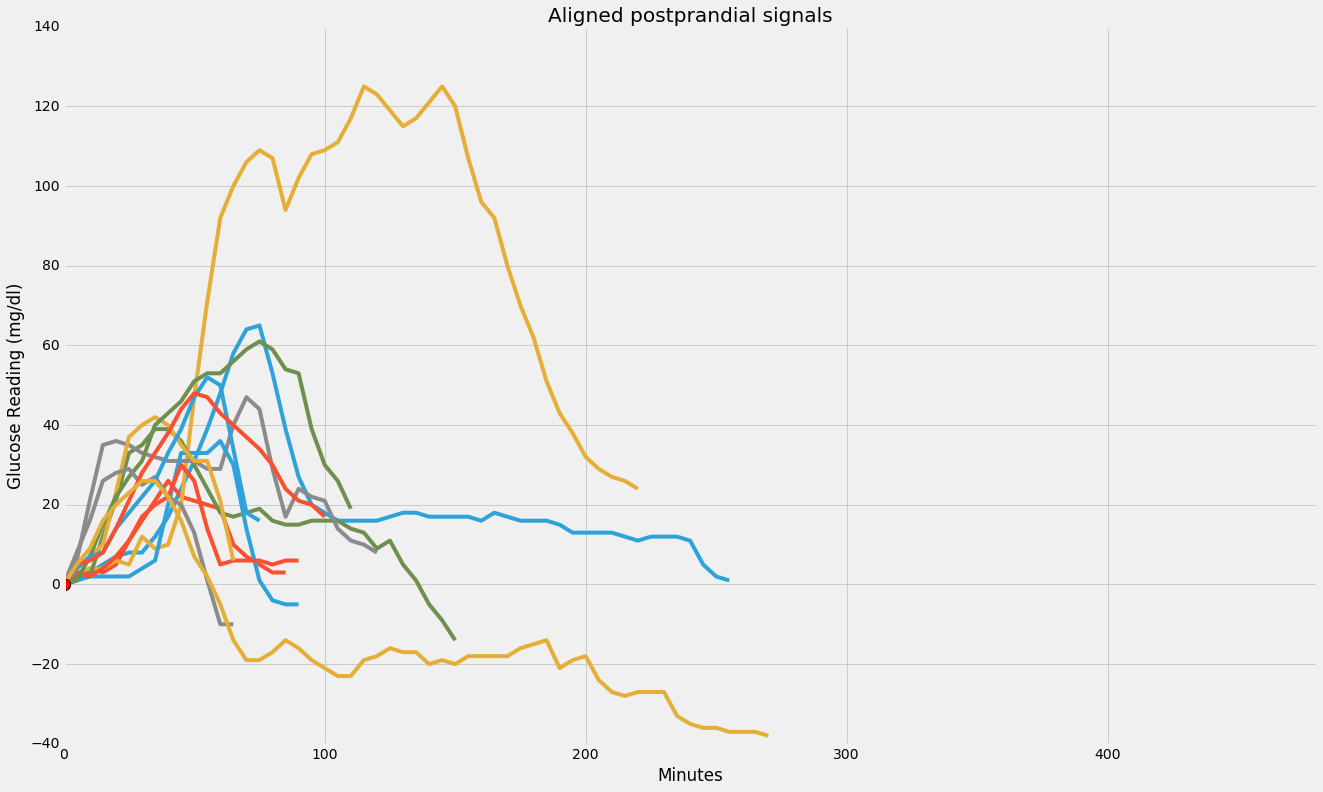

In [757]:
print "\nPlotting aligned postprandial signals for breakfast, lunch, dinner, respectively...\n", 
plotsaligned(all_breakfast_df, breakfast_df)#outputs aligned signals only
#plotsnormalized(all_breakfast_df, breakfast_df)#This outputs normalized signals of the aligned signals
  
#breakfast_signals_df = copy.deepcopy(signals_normalized_df)#this is for normalized output signals
breakfast_signals_df = copy.deepcopy(signals_aligned_df)#this is for aligned only output signals

plotsaligned(all_lunch_df, lunch_df)
#plotsnormalized(all_lunch_df, lunch_df)
  
lunch_signals_df = copy.deepcopy(signals_aligned_df)

plotsaligned(all_dinner_df, dinner_df)
#plotsnormalized(all_dinner_df, dinner_df)
   
dinner_signals_df = copy.deepcopy(signals_aligned_df)

### All postprandial signals combined

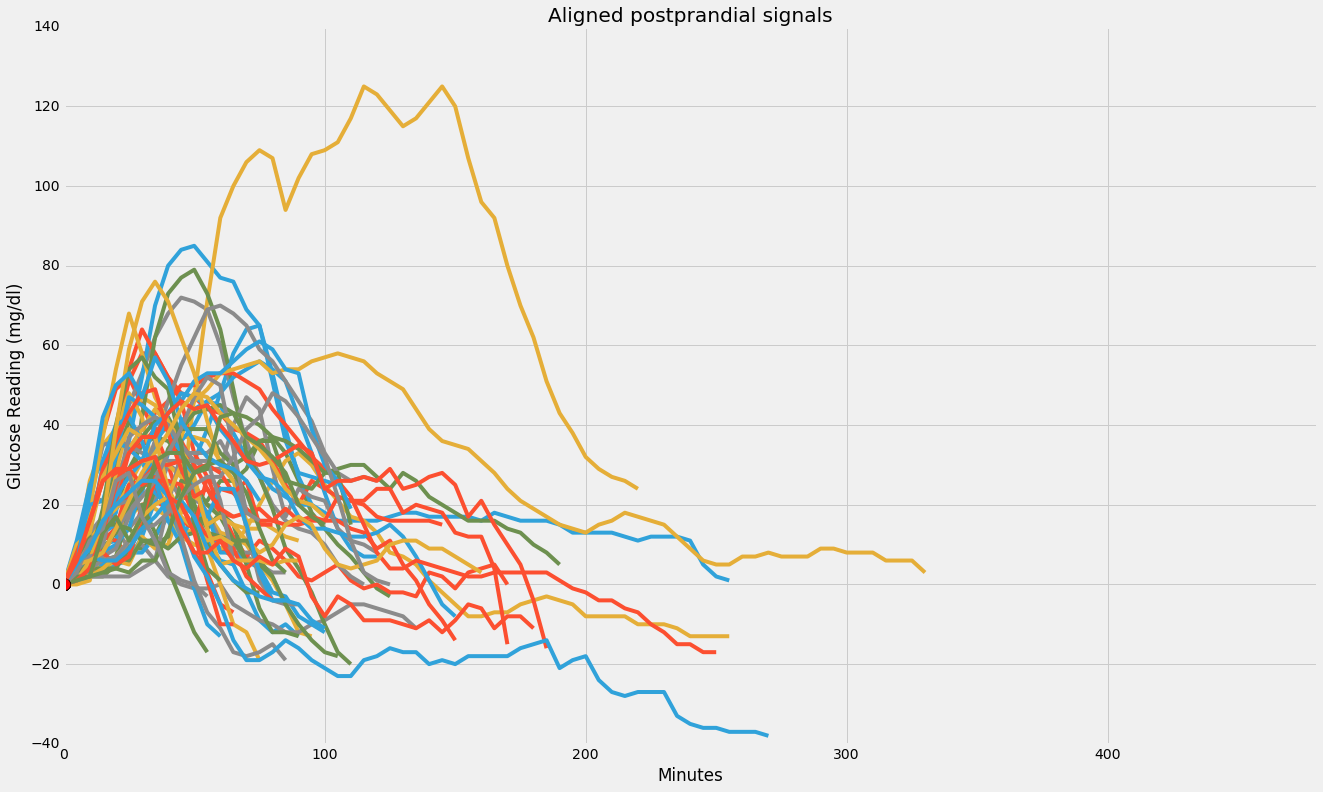

In [758]:
plotsaligned(all_combined_df, All_periods_df)
all_signals_df = copy.deepcopy(signals_aligned_df)

**It can be concluded that scaling (normalization) or standardization (also referred to normalization sometimes) are both not appropriate in our case since we want to preserve the differences between the various signals.**

**Average of the aligned signals for each of the periods**

### Remove signals with extreme outliers from each of the prandial periods

In [759]:
#print_full(breakfast_signals_df)

#Replace time instances with several nan BG concentrations with full column of nan, so it is not biased to specific signals
def replacenansignals(period_signal_df):

    for k in range(period_signal_df.shape[1]):
        #print breakfast_signals_df[breakfast_signals_df.columns[k]]
        xaxis_size =  period_signal_df.shape[0]
        total_nan = sum(pd.isnull(period_signal_df[period_signal_df.columns[k]]))
        available_readings = xaxis_size - total_nan
        #print available_readings

        if (available_readings < least_num_signals_per_inst):#if there are less than 4 signals at some time instance, don't consider them. Only if more than 3
            period_signal_df[period_signal_df.columns[k]] = np.nan
        #print period_signal_df[period_signal_df.columns[k]]     

print "Breakfast, checking for sufficient data points in the signal..."        
replacenansignals(breakfast_signals_df)
print "Lunch, checking for sufficient data points in the signal..." 
replacenansignals(lunch_signals_df)
print "Dinner, checking for sufficient data points in the signal..." 
replacenansignals(dinner_signals_df)  

replacenansignals(all_signals_df) 

Breakfast, checking for sufficient data points in the signal...
Lunch, checking for sufficient data points in the signal...
Dinner, checking for sufficient data points in the signal...


**Remove outlier signals, which have significant differences than others**

Steps:
1. Find 95% and 5% percentile at each time increment
2. If a signal falls several times outside the 95% and 5%, more than 5 times i.e, remove it

In [760]:
import scipy.stats as st

def get_percentile(period_df):
    global signal_upper_p 
    signal_upper_p = []
    global signal_lower_p
    signal_lower_p = []

    for k in range(period_df.shape[1]):
        temp_signal = []
        temp_signal = period_df.iloc[:,k][~np.isnan(period_df.iloc[:,k])]

        #print "length of signal is:", len(temp_signal), "and its content is: \n", temp_signal
        
        if (len(temp_signal) >= least_num_signals_per_inst):
            #95%percentile
            upper_p = np.percentile(temp_signal, 97.5)
            lower_p = np.percentile(temp_signal, 2.5)

            #print "upper p is:", upper_p, "and lower p is:", lower_p
            signal_upper_p.append(upper_p)
            signal_lower_p.append(lower_p)
    #return signal_upper_p, signal_lower_p

get_percentile(lunch_signals_df)

#print "Upper percentile: \n", signal_upper_p
#print "Lower percentile: \n", signal_lower_p
################

In [761]:
#Count the signals that have values outside the percentiles, if many then remove

def get_extreme_outliers(period_df):
    print "The size of the percentile array for this period is:", len(signal_upper_p)
    print "\nThe period contains the following number of signals:", period_df.shape[0], "\n"
    global extreme_outliers
    extreme_outliers = []
    for k in range(period_df.shape[0]):
        count = 0
        comparisons_pts = 0
        for i, item in enumerate(period_df.iloc[k]):
            if (i<len(signal_lower_p)  and (~math.isnan(item))):
                comparisons_pts += 1
                if ((item < signal_lower_p[i] or item > signal_upper_p[i])):
                    count += 1

        #print "The signal", k, "has", count , "extreme outliers out of", comparisons_pts,"points.\n"
      
        #condition to remove signals which are extreme and very rare, have over half (or one fourth) of their points outside the 95% percentile of the rest of signal points
        if (count>(comparisons_pts/3)):            
            extreme_outliers.append(k)
    print "The following signals are considered abnormal for having extreme outliers over the full signal spectrum:", extreme_outliers

#save the original period dataframes before removing the outliers
breakfast_org_df = copy.deepcopy(breakfast_signals_df)
lunch_org_df = copy.deepcopy(lunch_signals_df)
dinner_org_df = copy.deepcopy(dinner_signals_df)

#Breakfast
get_percentile(breakfast_signals_df)
print "\nRemove any abnormal signals from BREAKFAST period if they have several extreme outliers..."    
get_extreme_outliers(breakfast_signals_df)

breakfast_signals_df.drop(breakfast_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining breakfast signals are:", breakfast_signals_df.shape[0]
#Breakfast Dataframe with dates and meal info
#print "Size of breakfast df containing dates is:", all_breakfast_df.shape[0]
#all_breakfast_df.drop(all_breakfast_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of breakfast df containing dates is:", all_breakfast_df.shape[0]

#Lunch
get_percentile(lunch_signals_df)
print "\n\nRemove any abnormal signals from LUNCH period if they have several extreme outliers..." 
get_extreme_outliers(lunch_signals_df)
lunch_signals_df.drop(lunch_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining lunch signals are:", lunch_signals_df.shape[0]
#Lunch Dataframe with dates and meal info
#print "Size of lunch df containing dates is:", all_lunch_df.shape[0]
#all_lunch_df.drop(all_lunch_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of lunch df containing dates is:", all_lunch_df.shape[0]

#Dinner
get_percentile(dinner_signals_df)
print "\n\nRemove any abnormal signals from DINNER period if they have several extreme outliers..."     
get_extreme_outliers(dinner_signals_df) 
dinner_signals_df.drop(dinner_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining dinner signals are:", dinner_signals_df.shape[0]
#Dinner Dataframe with dates and meal info
#print "Size of dinner df containing dates is:", all_dinner_df.shape[0]
#all_dinner_df.drop(all_dinner_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of dinner df containing dates is:", all_dinner_df.shape[0]    

#All prandial signals
get_percentile(all_signals_df)
print "\n\nRemove any abnormal signals from All prandial periods combined if they have several extreme outliers..."     
get_extreme_outliers(all_signals_df) 
all_signals_df.drop(all_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining signals are:", all_signals_df.shape[0]
#Dinner Dataframe with dates and meal info
#print "Size of dinner df containing dates is:", all_dinner_df.shape[0]
#all_signals_df.drop(all_signals_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of dinner df containing dates is:", all_dinner_df.shape[0]  

all_combined_df.drop(all_combined_df.index[extreme_outliers], axis=0,inplace=True)




Remove any abnormal signals from BREAKFAST period if they have several extreme outliers...
The size of the percentile array for this period is: 37

The period contains the following number of signals: 23 

The following signals are considered abnormal for having extreme outliers over the full signal spectrum: [11]

Remaining breakfast signals are: 22


Remove any abnormal signals from LUNCH period if they have several extreme outliers...
The size of the percentile array for this period is: 35

The period contains the following number of signals: 23 

The following signals are considered abnormal for having extreme outliers over the full signal spectrum: []

Remaining lunch signals are: 23


Remove any abnormal signals from DINNER period if they have several extreme outliers...
The size of the percentile array for this period is: 31

The period contains the following number of signals: 13 

The following signals are considered abnormal for having extreme outliers over the full signal s

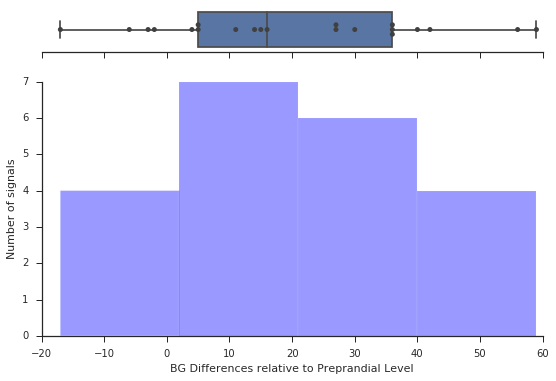

In [762]:
#display the box plot for the values at some time increment distribution, showing the 97.5% and 2.5% percentiles

import seaborn as sns

sns.set(style="ticks")

#print lunch_signals_df

time_instance = 15 #i.e: location is 15 * 5mins increments = 60mins

xaxis_size =  lunch_signals_df.shape[0]
total_nan = sum(pd.isnull(lunch_signals_df[lunch_signals_df.columns[time_instance]]))
available_readings = xaxis_size - total_nan
#print available_readings

if (available_readings >= least_num_signals_per_inst):#if there are less than 3 signals at some time instance, don't consider them. Only if more than 3


    temp_signal = []
    temp_signal = lunch_signals_df.iloc[:,time_instance][~np.isnan(lunch_signals_df.iloc[:,time_instance])]
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    b = sns.boxplot(temp_signal, ax=ax_box)
    sns.swarmplot(temp_signal, ax=ax_box, color=".25")
    h = sns.distplot( temp_signal, ax=ax_hist, kde=False, color='b')

    h.set(xlabel='BG Differences relative to Preprandial Level', ylabel='Number of signals')
    b.set(xlabel='')

    ax_box.set( yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
else:
    print "Not enough readings at this time instance to visualize!"
sns.reset_orig()

### BG Differences relative to Preprandial Level

In [763]:
breakfast_signals_df_cleaned = copy.deepcopy(breakfast_signals_df)
lunch_signals_df_cleaned = copy.deepcopy(lunch_signals_df)
dinner_signals_df_cleaned = copy.deepcopy(dinner_signals_df)
all_signals_df_cleaned = copy.deepcopy(all_signals_df)

#Here, we omit the instances that do not have significant amount of readings because a distribution based on them can be biased
def Remove_nan_instances(signals_df):
    xaxis_size =  signals_df.shape[0]
    yaxis_size =  signals_df.shape[1]
    for j in range(yaxis_size):
        total_nan = sum(pd.isnull(signals_df[signals_df.columns[j]]))
        available_readings = xaxis_size - total_nan
        if (available_readings < least_num_signals_per_inst):
            #print "j is :", j
            signals_df.iloc[:,j] = np.nan
        
Remove_nan_instances(breakfast_signals_df_cleaned)   
Remove_nan_instances(lunch_signals_df_cleaned) 
Remove_nan_instances(dinner_signals_df_cleaned) 
Remove_nan_instances(all_signals_df_cleaned) 

In [764]:
import plotly.plotly as py
from numpy import *
print "\nBG Difference between Preprandial and postprandial concentrations at different time instances for ALL prandial periods\n"  
N =  all_signals_df_cleaned.shape[1] # Number of boxes

#print "Total Duration is ",N*5 , "mintues."
# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y': all_signals_df_cleaned.iloc[:,i][~np.isnan(all_signals_df_cleaned.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]


# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data) 


BG Difference between Preprandial and postprandial concentrations at different time instances for ALL prandial periods



In [765]:

print "\n-----------------BG Difference between Preprandial and postprandial concentrations at different time instances for BREAKFAST-----\n"  
N =  breakfast_signals_df_cleaned.shape[1] # Number of boxes

#print "Total Duration is ",N*5 , "mintues."
# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y': breakfast_signals_df_cleaned.iloc[:,i][~np.isnan(breakfast_signals_df_cleaned.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]


# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data)   


-----------------BG Difference between Preprandial and postprandial concentrations at different time instances for BREAKFAST-----



In [766]:
print "\n-----------------BG Difference between Preprandial and postprandial concentrations at different time instances for Lunch-----\n"    

N =  lunch_signals_df_cleaned.shape[1] # Number of boxes

#print N
# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y': lunch_signals_df_cleaned.iloc[:,i][~np.isnan(lunch_signals_df_cleaned.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]


# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data)  


-----------------BG Difference between Preprandial and postprandial concentrations at different time instances for Lunch-----



In [767]:
print "\n-----------------BG Difference between Preprandial and postprandial concentrations at different time instances for Dinner-----\n"      
N =  dinner_signals_df_cleaned.shape[1] # Number of boxes

#print N
# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y': dinner_signals_df_cleaned.iloc[:,i][~np.isnan(dinner_signals_df_cleaned.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]


# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data)     


-----------------BG Difference between Preprandial and postprandial concentrations at different time instances for Dinner-----



From the above plot, we can conclude that the error decreases overtime.

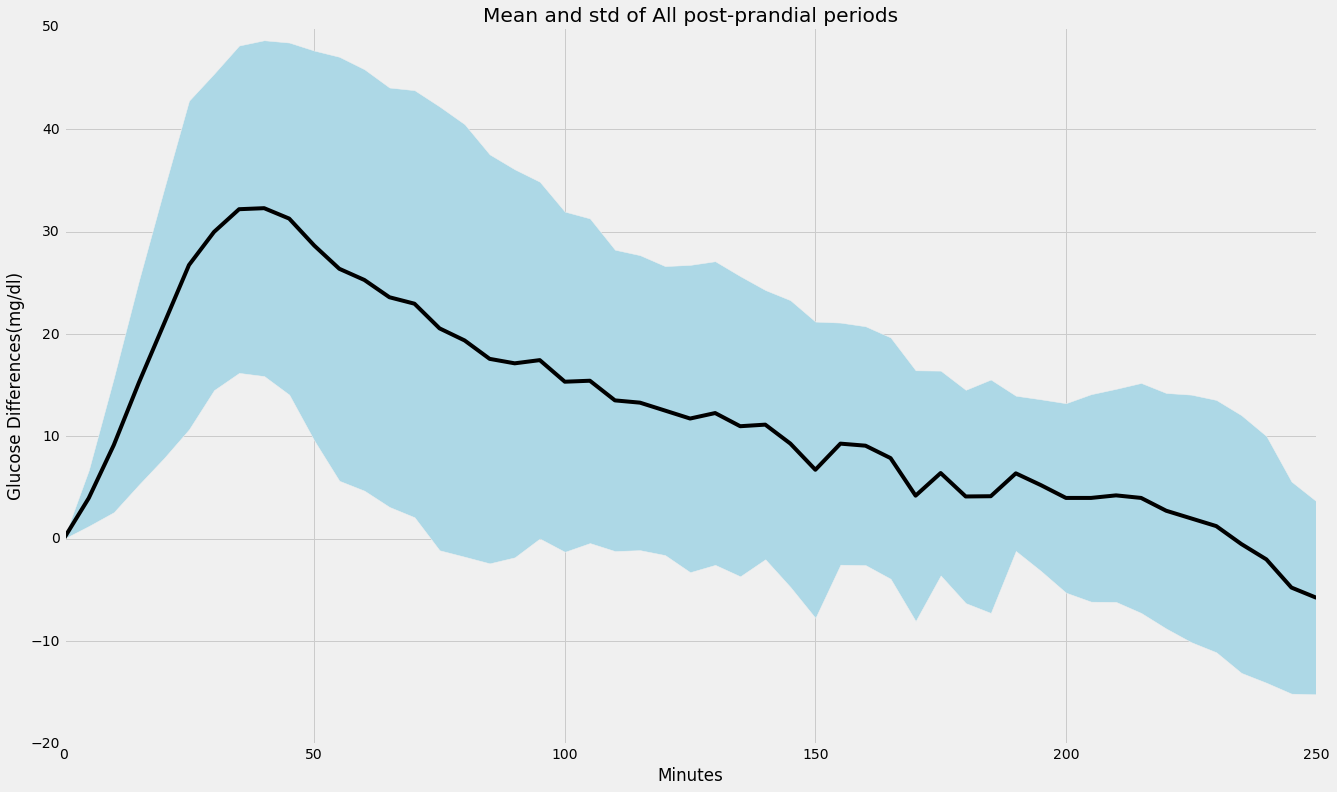

In [768]:
#Plotting mean and std of all postprandial signals combined
postmeal_all_mean = np.nanmean(all_signals_df_cleaned, axis=0)
postmeal_all_std = np.nanstd(all_signals_df_cleaned, axis=0)
x_axis = [x*5 for x in range(all_signals_df_cleaned.shape[1])]
plt.figure(figsize=(20,12))
plt.plot(x_axis, postmeal_all_mean, 'k-')
plt.fill_between(x_axis, postmeal_all_mean-postmeal_all_std, postmeal_all_mean+postmeal_all_std,facecolor='lightblue')
plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of All post-prandial periods'
plt.title(title);

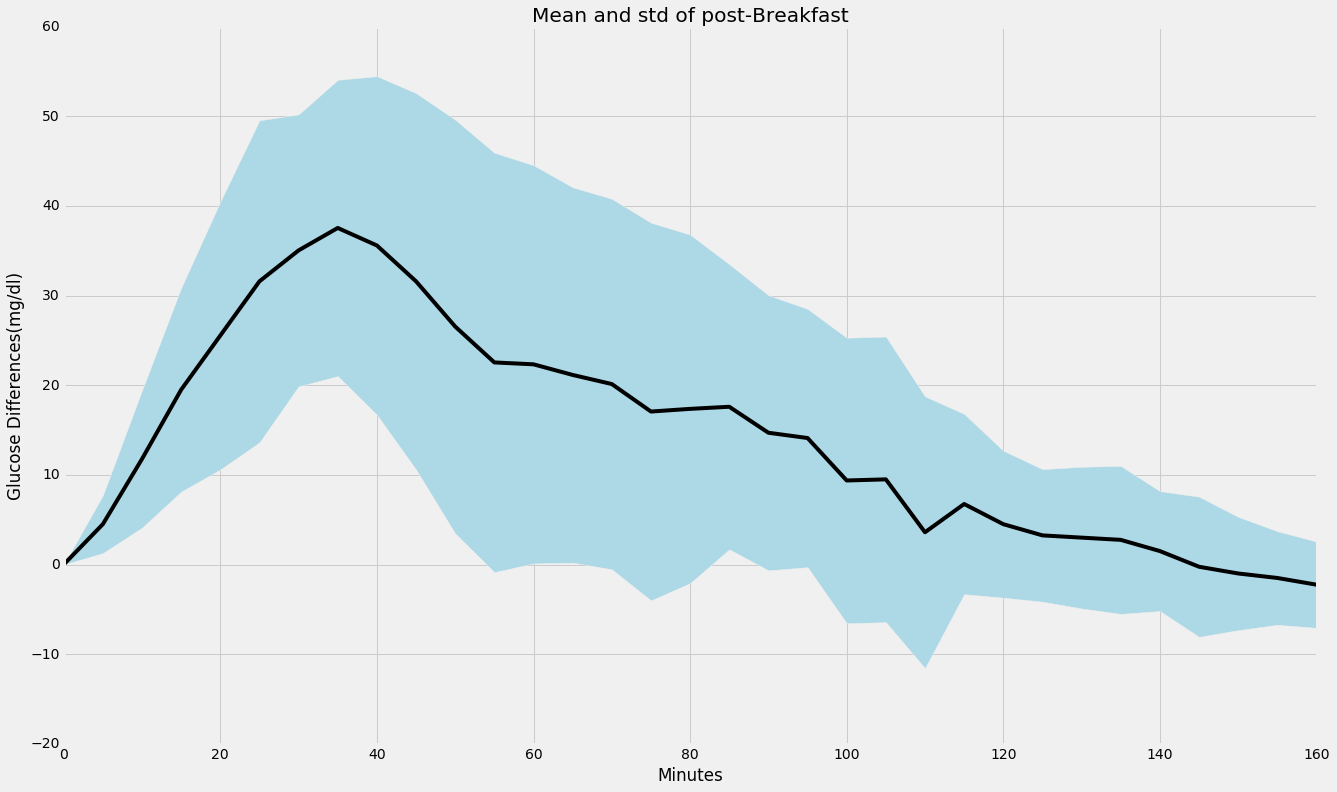

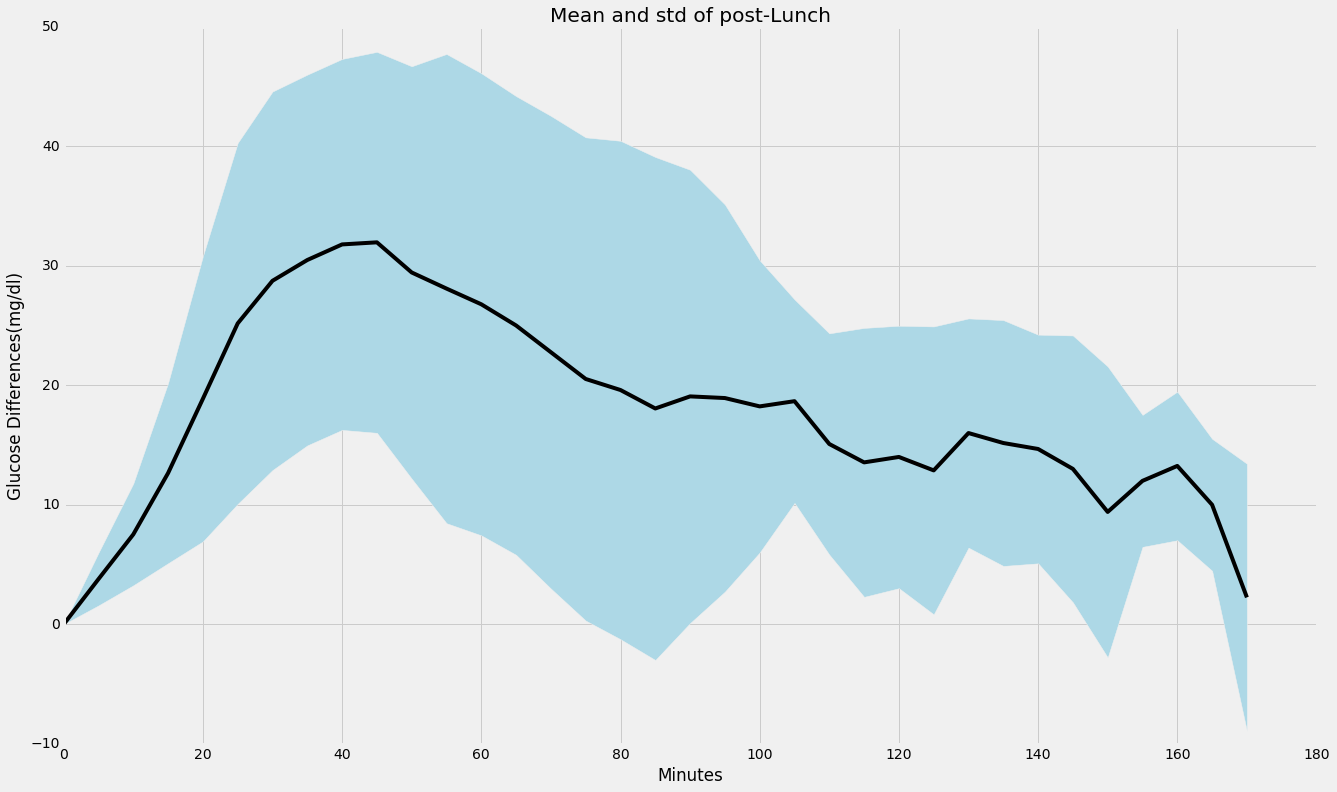

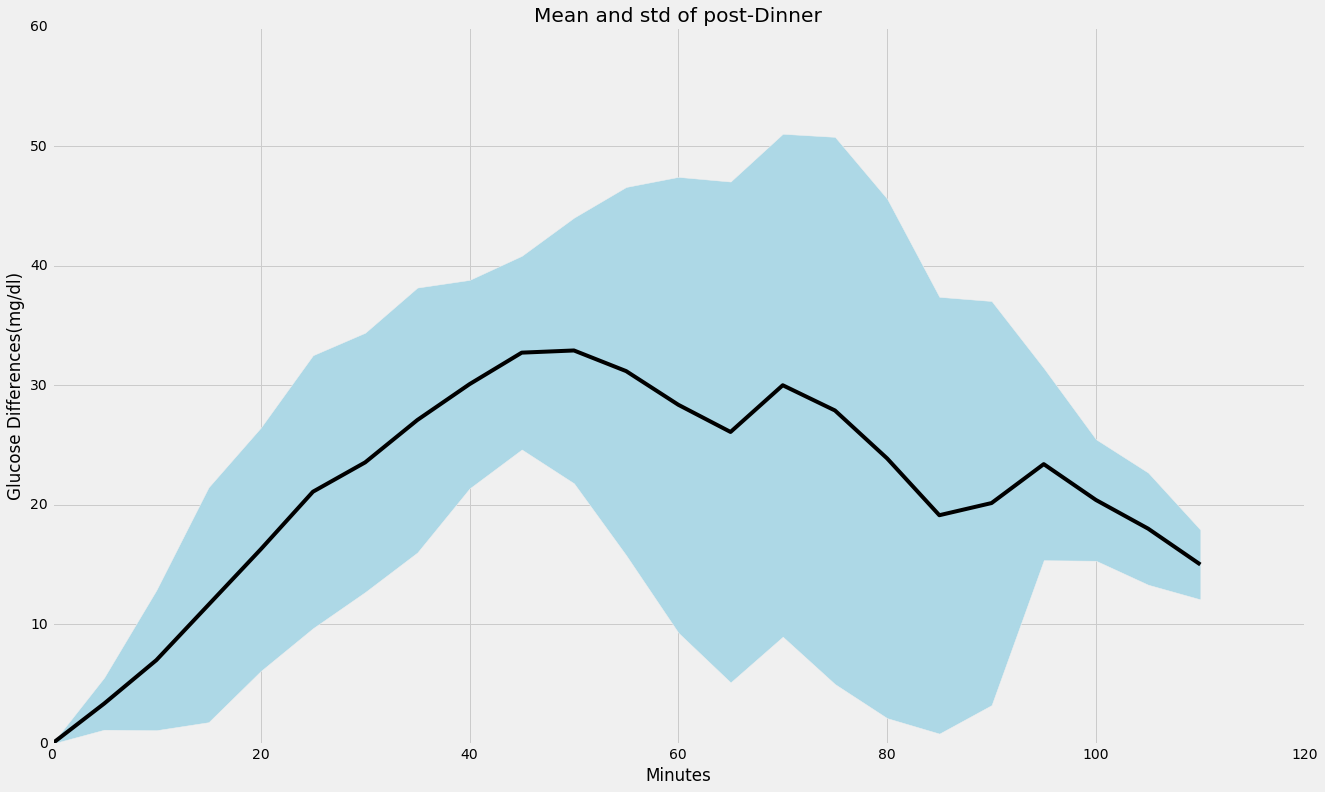

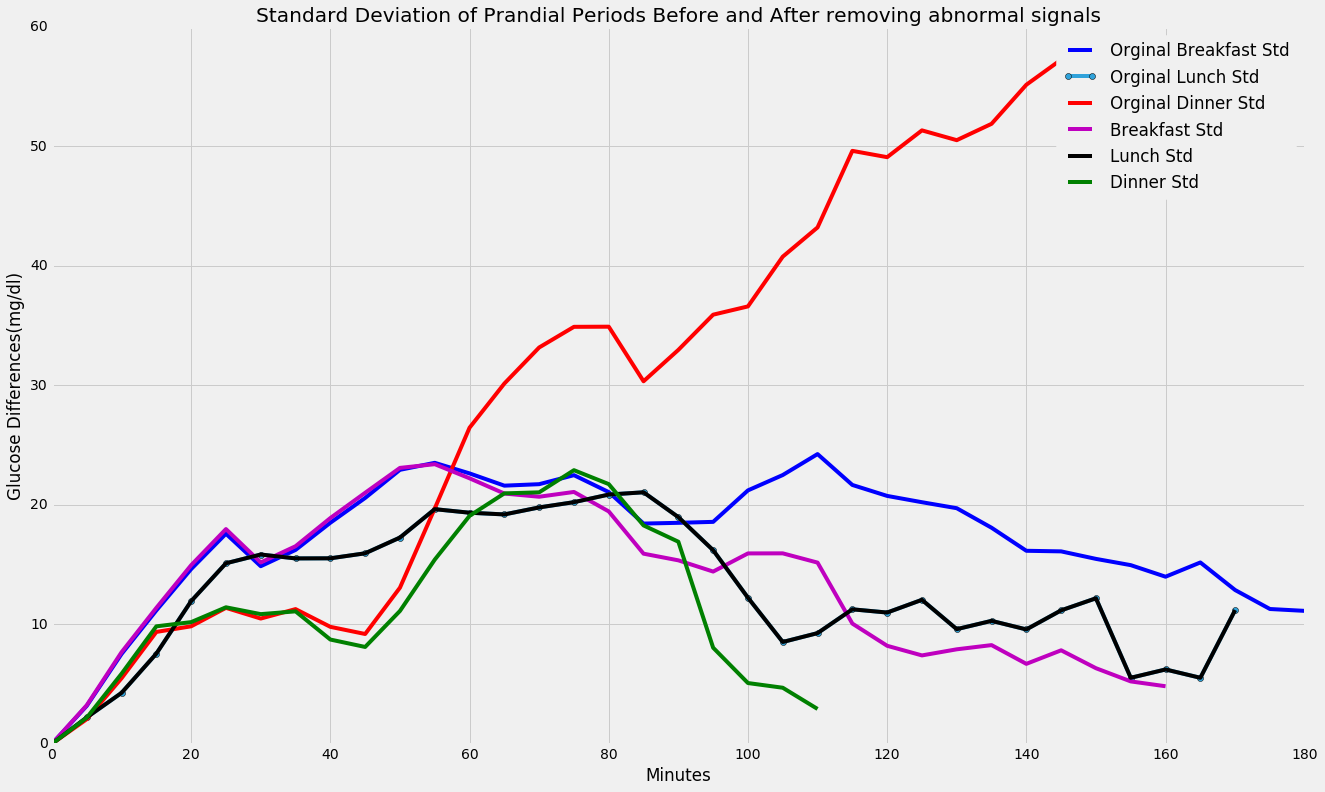

In [769]:
#Calculate the mean at each time increment after meal
 
postmeal_breakfast_mean = np.nanmean(breakfast_signals_df_cleaned, axis=0)
postmeal_breakfast_std = np.nanstd(breakfast_signals_df_cleaned, axis=0)
#print "Number of 5mins increments in the lunch df is:", lunch_signals_df.shape[1]
postmeal_lunch_mean = np.nanmean(lunch_signals_df_cleaned, axis=0)
postmeal_lunch_std = np.nanstd(lunch_signals_df_cleaned, axis=0)

#print "Number of 5mins increments in the dinner df is:", dinner_signals_df.shape[1]
postmeal_dinner_mean = np.nanmean(dinner_signals_df_cleaned, axis=0)
postmeal_dinner_std = np.nanstd(dinner_signals_df_cleaned, axis=0)

x_axis = [x*5 for x in range(breakfast_signals_df_cleaned.shape[1])]
#print len(x_axis)

#plt.plot(peak_elapsed_t[j], postmeal_breakfast_std, 'y*', markersize=20)
#print postmeal_breakfast_std

plt.figure(figsize=(20,12))
# #hold on
plt.plot(x_axis, postmeal_breakfast_mean, 'k-')
#print "mean of breakfast signals is:", postmeal_breakfast_mean
#print "std of breakfast signals is:", postmeal_breakfast_std
plt.fill_between(x_axis, postmeal_breakfast_mean-postmeal_breakfast_std, postmeal_breakfast_mean+postmeal_breakfast_std,facecolor='lightblue')
plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of post-Breakfast'
plt.title(title);


x_axis = [x*5 for x in range(lunch_signals_df_cleaned.shape[1])]
plt.figure(figsize=(20,12))
# #hold on
plt.plot(x_axis, postmeal_lunch_mean, 'k-')
plt.fill_between(x_axis, postmeal_lunch_mean-postmeal_lunch_std, postmeal_lunch_mean+postmeal_lunch_std,facecolor='lightblue')

plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of post-Lunch'
plt.title(title);

x_axis = [x*5 for x in range(dinner_signals_df_cleaned.shape[1])]
plt.figure(figsize=(20,12))
# #hold on
plt.plot(x_axis, postmeal_dinner_mean, 'k-')
plt.fill_between(x_axis, postmeal_dinner_mean-postmeal_dinner_std, postmeal_dinner_mean+postmeal_dinner_std,facecolor='lightblue')
plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of post-Dinner'
plt.title(title);


#Plotting std for all periods
plt.figure(figsize=(20,12))

######################################
####Compare std after removing extreme outliers
org_breakfast_mean = np.nanmean(breakfast_org_df, axis=0)
org_breakfast_std = np.nanstd(breakfast_org_df, axis=0)

org_lunch_mean = np.nanmean(lunch_org_df, axis=0)
org_lunch_std = np.nanstd(lunch_org_df, axis=0)

org_dinner_mean = np.nanmean(dinner_org_df, axis=0)
org_dinner_std = np.nanstd(dinner_org_df, axis=0)

plt.plot(x_axis, org_breakfast_std, 'b-', label = 'Orginal Breakfast Std')
plt.plot(x_axis, org_lunch_std, 'o-', label = 'Orginal Lunch Std')
plt.plot(x_axis, org_dinner_std, 'r-',  label = 'Orginal Dinner Std')

plt.plot(x_axis, postmeal_breakfast_std, 'm-', label = 'Breakfast Std')
plt.plot(x_axis, postmeal_lunch_std, 'k-', label = 'Lunch Std')
plt.plot(x_axis, postmeal_dinner_std, 'g-',  label = 'Dinner Std')

###########

plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Standard Deviation of Prandial Periods Before and After removing abnormal signals'.format(after_reading)
plt.title(title);

### Minimize any BG increase after the peak

We are expecting that BG does not increase past 90 minutes, so if there is an increase on the mean signal we will reduce it to a minimum by multipying by a small factor.

In [770]:
#after 90 minutes, if BG is decreasing => multiply difference between bg of that time instance and lowest point by 0.1

#when next point has bg less than previous lowest bg point, set the new point as the lowest bg point

def decrease_postpeak_variance(prandial_period, plot_show):
    global prandial_mean_wo_nan 
    #Get mean of prandial period
    prandial_mean = np.mean(prandial_period)
    prandial_mean_instances = [round(item,1) for x, item in enumerate(prandial_mean)]
    #print prandial_mean_instances

    #Set all BG readings occuring after 90 minutes to be decreasing, 90 minutes is equivalent to index 90/5 = 18

    i = 90/5
    current_gl = prandial_mean_instances[i]

    while (i<(len(prandial_mean_instances)-1)):
            if (prandial_mean_instances[i+1]>current_gl):
                prandial_mean_instances[i+1] = round(((prandial_mean_instances[i+1]-current_gl) *0.2) + current_gl, 1)
            else:
                prandial_mean_instances[i+1] = round(prandial_mean_instances[i+1] *0.9 , 1)
                current_gl = prandial_mean_instances[i+1]
            i += 1    

    #print prandial_mean_instances

#     if (plot_show == True):
#         x_axis = [x*5 for x in range(len(prandial_mean_instances))]
#         plt.figure(figsize=(20,12))
#         #hold on
#         plt.plot(x_axis, prandial_mean_instances, 'k-')
#         plt.show()
    


    prandial_mean_wo_nan = []
    y = [~np.isnan(prandial_mean_instances[:])]
    for k, x in enumerate(prandial_mean_instances):
        if (y[0][k] == True):
            prandial_mean_wo_nan.append(x)

    #print prandial_mean_wo_nan




In [771]:
import copy
import statsmodels.api as sm

def curvefit(signal_pts, wonan, plot_show): 
    
    plot_indeces_all = map(lambda v : v * 5, range(45)) 
    #print signal_pts
    
    if (wonan==False):
        y = signal_pts[:][~np.isnan(signal_pts[:])]
    else:
        y = signal_pts
        

    #print y

    plot_indeces = map(lambda v : v * 5, range(len(y)))
    x = plot_indeces   

    ###############
    #The polonomial should start from 5 mins instead of 0 mins, so we do not force that y(0) = 0 
    x_v1 = copy.deepcopy(x)
    y_v1 = copy.deepcopy(y)
    x_v1.pop(0)
    y_v1.pop(0)
    ################
    
    p = np.poly1d(np.polyfit(x_v1, y_v1, deg=5))

    #print "\nThe polynomial fitting of the data is:\n\n",p  
    
    
####smoothing
    lowess = sm.nonparametric.lowess(y, x, frac=0.2)   
    #print lowess
    global plot_indeces2, x_v2
    
    plot_indeces2 = map(lambda v : v * 5, range(len(lowess[:, 1])))
    x2 = plot_indeces2   

    ###############
    #The polonomial should start from 5 mins instead of 0 mins, so we do not force that y(0) = 0 
    x_v2 = copy.deepcopy(x2)
    x_v2.pop(0)
    #print x_v2
    #print len(x_v2)
    #print len(lowess[1:, 1])
    ################
    
    
    global p2
    p2 = np.poly1d(np.polyfit(x_v2, lowess[1:, 1], deg=5))
    
    global fig_v1, ax_v1
    
    if (plot_show == True):
        fig_v1, ax_v1 = plt.subplots(figsize=(20,15))

        ax_v1.plot(plot_indeces, y, label= 'Period Mean Data Points')  
        #ax.plot(plot_indeces, p(plot_indeces), label = 'Fitted Curve')   
        ax_v1.plot(lowess[:, 0], lowess[:, 1], label = 'Smoothed Curve')  
        ax_v1.plot(x_v2, p2(x_v2), label = 'Fitted Smoothed Curve')
        #ax_v1.plot(plot_indeces_all, p2(plot_indeces_all), label = 'Extrapolation of Smoothed Curve', linestyle='--')   

        legend = ax_v1.legend(shadow=True) 
        #plt.show()



In [772]:
print "Prandial mean for breakfast...\n"
plot_show = True
decrease_postpeak_variance(breakfast_signals_df_cleaned, plot_show)    

# print "Original signal...\n"#without adjustement of minimizing any BG increase
# wonan = False    
# curvefit(postmeal_breakfast_mean,wonan)  


print "Adjusted signal, scaled down any post-peak increase...\n"
wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)
breakfast_indeces = copy.deepcopy(x_v2)
p_breakfast = p2

print prandial_mean_wo_nan

Prandial mean for breakfast...



TypeError: list indices must be integers, not float

In [ ]:
plot_show = True
print "Prandial mean for lunch...\n"
decrease_postpeak_variance(lunch_signals_df_cleaned, plot_show)     

# print "Original signal...\n"
# wonan = False    
# curvefit(postmeal_lunch_mean,wonan)  

print "Adjusted signal, scaled down any post-peak increase...\n"
wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)  
lunch_indeces = copy.deepcopy(x_v2)
p_lunch = p2

In [ ]:
plot_show = True
print "Prandial mean for dinner...\n"
decrease_postpeak_variance(dinner_signals_df_cleaned, plot_show)    

# print "Original signal...\n"
# wonan = False    
# curvefit(postmeal_dinner_mean,wonan)  

print "Adjusted signal, scaled down any post-peak increase...\n"

wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)
dinner_indeces = copy.deepcopy(x_v2)
p_dinner = p2

In [ ]:
plot_show = True
print "Prandial mean from ALL signals...\n"
decrease_postpeak_variance(all_signals_df_cleaned, plot_show)    

# print "Original signal...\n"
# wonan = False    
# curvefit(postmeal_dinner_mean,wonan)  

print "Adjusted signal, scaled down any post-peak increase...\n"

wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)
all_combined_indeces = copy.deepcopy(x_v2)
p_all_combined = p2

In [ ]:
fig_v1, ax_v1 = plt.subplots(figsize=(20,15))

ax_v1.plot(breakfast_indeces, p_breakfast(breakfast_indeces), label = 'Fitted Curve for Breakfast')
ax_v1.plot(lunch_indeces, p_lunch(lunch_indeces), label = 'Fitted Curve for Lunch')
ax_v1.plot(dinner_indeces, p_dinner(dinner_indeces), label = 'Fitted Curve for Dinner')
ax_v1.plot(all_combined_indeces, p_all_combined(all_combined_indeces), label = 'Fitted Curve for periods Combined')

legend = ax_v1.legend(shadow=True) 
plt.show()

**Let's first try to curve fit the signals. If well fitted, we will try to map food intake to polynomial coeffecients.**

## Leave One Out Cross-Validation

Leave one signal out, find error after training on the rest of the signals.
Get average error for all signals.

In [ ]:
#breakfast_signals_df contains the all the breakfast signals

#Leave out one signal, get the mean of others, get error for all points on the left out signal
#print_full(breakfast_signals_df)

from operator import sub
from astropy.stats import median_absolute_deviation
import copy

breakfast_training_df = copy.deepcopy(breakfast_signals_df_cleaned)
lunch_training_df = copy.deepcopy(lunch_signals_df_cleaned)
dinner_training_df = copy.deepcopy(dinner_signals_df_cleaned)
all_training_df = copy.deepcopy(all_signals_df_cleaned)


signal_visualize = False

test_signal_num = 0 

def set_training_testing_sets(full_train_df):
    

    global train_df, test_series_wonan
    global test_signal_num
    
    #for k in range(13,14):
    for k in range(full_train_df.shape[0]):
        #train_df = pd.DataFrame(index=full_train_df.index, columns=full_train_df.columns)
        #train_df = train_df.fillna(0)
        #print "\n---------------------------------"
        #print "\nIndex of current test signal in the dataframe is:", k
        test_signal_num = k
        train_df = copy.deepcopy(full_train_df)
        test_series = train_df.iloc[k]
        test_series_wonan = test_series[:][~np.isnan(test_series[:])]
        #print "Current testing signal is:\n", test_series_wonan
        train_df.drop(train_df.index[k],axis=0,inplace=True)
        train_df = train_df.reset_index(drop=True) 
        
        get_signal_error(train_df, test_series_wonan)
    #return train_df, test_series_wonan

def get_signal_error(train_df, test_series_wonan):
    global signal_visualize
    global test_error_df
    global prandial_mean_wo_nan
    x_axis_test = []
    if (signal_visualize == True):
        plot_show = True
    else:        
        plot_show = False
    decrease_postpeak_variance(train_df, plot_show) 
   
    #######################
    plot_show = False    
    wonan = True  
    curvefit(prandial_mean_wo_nan,wonan, plot_show)
    
    #print "\nDuration of this test signal is:", len(test_series_wonan)*5, "minutes.\n"

    #print p2(x_v2)[:], "its length is ", len(p2(x_v2)[:])
    #print prandial_mean_wo_nan , "its length is ", len(prandial_mean_wo_nan)
    prandial_mean_wo_nan = copy.deepcopy(p2(x_v2).tolist())
    
    if (len(test_series_wonan[1:])>= len(prandial_mean_wo_nan)):
        for l in drange(0, (len(prandial_mean_wo_nan)-1)*5, 5):
            x_axis_test.append(l)
    else:
        for l in drange(0, (len(test_series_wonan)-2)*5, 5):#-2 because we do not include first reading at 0
            x_axis_test.append(l)   
    
    #print len(prandial_mean_wo_nan[:len(x_axis_test)])
    #print len(test_series_wonan.tolist()[1:])
    error_diff = list(map(sub, prandial_mean_wo_nan[:len(x_axis_test)], test_series_wonan.tolist()[1:]))
    error_diff = [abs(round(x,2)) for x in error_diff]
    #printing array with all errors
    #print error_diff
    
    error_diff_full = copy.deepcopy(error_diff)
    
    #until the size of the plot 
    if ((window_size/5) > len(error_diff)):
        for j in range((window_size/5) - len(error_diff)):
            error_diff_full.append(float('nan'))           
    else: 
        error_diff_full = error_diff[:(window_size/5)]
    
    test_error_df.loc[test_signal_num] = error_diff_full
    print "\nMean Absolute Error (MAE) is:", np.mean(error_diff), "with a std of", np.std(error_diff), "and a Mean Absolute Deviation (MAD) of", median_absolute_deviation(error_diff)

    #print "test signal num is:", test_signal_num

In [ ]:
#print "\n Test signal Error dataframe is:" , test_error_df
def plot_test_error():
    global test_error_df_v2

    test_error_df_v2 = copy.deepcopy(test_error_df)

    #dont plot readings at 0 so insert nan at column of 0
    test_error_df_v2.iloc[:,0] = np.nan
    for k in range(test_error_df_v2.shape[1]-1):
        test_error_df_v2.iloc[:,k+1] = test_error_df.iloc[:,k]
    print test_error_df_v2.shape[1]
    
    plt.figure(figsize=(20,12))
    #for j in range(0,10):
    for j in range(len(test_error_df_v2)):
        row = test_error_df_v2.iloc[j]
        row.plot()
    
    
    #print_full(test_error_df)
    plt.xlabel('Minutes')
    plt.ylabel('Forecast Error (mg/dl)')
    #plt.legend(loc='upper right')
    title = 'Error of Leave One Out Test over Full Postprandial Period'
    plt.title(title)

    plt.show()

In [ ]:
print "\n-----------------------Leave One Out On Breakfast Period------------------\n"

#Make sure to uncomment the above: for k in range(full_train_df.shape[0]):
window_size = 300  # 400 mintues, size of plot
Plot_win = [i for i in np.arange(0, window_size, incr)]
test_error_df = pd.DataFrame(columns=Plot_win)

set_training_testing_sets(breakfast_training_df)
plot_test_error()
breakfast_df_errors = copy.deepcopy(test_error_df_v2)

In [ ]:
print "\n-----------------------Leave One Out On Lunch Period------------------\n"
#Make sure to uncomment the above: for k in range(full_train_df.shape[0]):
window_size = 300  # 400 mintues, size of plot
Plot_win = [i for i in np.arange(0, window_size, incr)]
test_error_df = pd.DataFrame(columns=Plot_win)
set_training_testing_sets(lunch_training_df)
plot_test_error()
lunch_df_errors = copy.deepcopy(test_error_df_v2)

In [ ]:
print "\n-----------------------Leave One Out On Dinner Period------------------\n"
#Make sure to uncomment the above: for k in range(full_train_df.shape[0]):
window_size = 300  # 400 mintues, size of plot
Plot_win = [i for i in np.arange(0, window_size, incr)]
test_error_df = pd.DataFrame(columns=Plot_win)
set_training_testing_sets(dinner_training_df)
plot_test_error()
dinner_df_errors = copy.deepcopy(test_error_df_v2)

In [ ]:
print "\n-----------------------Leave One Out On All Periods Combined------------------\n"

#Make sure to uncomment the above: for k in range(full_train_df.shape[0]):
window_size = 300  # 400 mintues, size of plot
Plot_win = [i for i in np.arange(0, window_size, incr)]
test_error_df = pd.DataFrame(columns=Plot_win)

set_training_testing_sets(all_training_df)
plot_test_error()
all_df_errors = copy.deepcopy(test_error_df_v2)

In [ ]:
##########To visualize a test signal, use code below..... but make sure to uncomment the following above
#for k in range(10,11)
#wonan = True  
#curvefit(prandial_mean_wo_nan,wonan, plot_show)

#####################################Working well, just uncomment to visualize one signal

# signal_visualize = True
# set_training_testing_sets(all_training_df) 

# if (len(test_series_wonan)>= len(prandial_mean_wo_nan)):
#     x_axis_test = [x*5 for x in range(len(prandial_mean_wo_nan))]
#     ax_v1.plot(x_axis_test, test_series_wonan[:len(prandial_mean_wo_nan)], label = 'Test Signal', linestyle='--')
# else:    
#     x_axis_test = [x*5 for x in range(len(test_series_wonan))]
#     ax_v1.plot(x_axis_test, test_series_wonan[:len(test_series_wonan)], label = 'Test Signal', linestyle='--') 

# legend = ax_v1.legend(shadow=True)
# plt.show()

###########################################

### Plotting of the mean absolute error (MAE) at each time instance over the full postprandial spectrum

In [ ]:
print "\nThe analysis was done on:\n"
print "     ", breakfast_df_errors.shape[0], "Breakfast meals"
print "     ", lunch_df_errors.shape[0], "Lunch meals"
print "     ", dinner_df_errors.shape[0], "Dinner meals"

print "\n     ", all_df_errors.shape[0], "of all combined"

mean_breakfast_period = np.mean(breakfast_df_errors)
mean_lunch_period = np.mean(lunch_df_errors)
mean_dinner_period = np.mean(dinner_df_errors)
mean_all_period = np.mean(all_df_errors)

plt.figure(figsize=(20,12))
####with smoothing

#plt.plot(Plot_win, mean_breakfast_period, 'g-', label = 'Breakfast')
lowess = sm.nonparametric.lowess(mean_breakfast_period, Plot_win, frac=0.1)   
plt.plot(lowess[:, 0], lowess[:, 1], 'g-', label = 'Breakfast, {} meals'.format(breakfast_df_errors.shape[0]) ) 

#plt.plot(Plot_win, mean_lunch_period, 'r-', label = 'Lunch')
lowess = sm.nonparametric.lowess(mean_lunch_period, Plot_win, frac=0.1)   
plt.plot(lowess[:, 0], lowess[:, 1], 'r-', label = 'Lunch, {} meals'.format(lunch_df_errors.shape[0]) )  

#plt.plot(Plot_win, mean_dinner_period, 'b-', label = 'Dinner')
lowess = sm.nonparametric.lowess(mean_dinner_period, Plot_win, frac=0.1)   
plt.plot(lowess[:, 0], lowess[:, 1], 'b-', label = 'Dinner, {} meals'.format(dinner_df_errors.shape[0]) ) 

#plt.plot(Plot_win, mean_all_period, 'm-', label = 'All Combined')
lowess = sm.nonparametric.lowess(mean_all_period, Plot_win, frac=0.1)   
plt.plot(lowess[:, 0], lowess[:, 1], 'm-', label = 'All daily meals combined, {} meals'.format(all_df_errors.shape[0]) )  

plt.xlabel('Minutes')
plt.ylabel('Mean Absolute Error (mg/dl)')
plt.legend(loc='upper right')
title = 'Leave One Out Mean Absolute Error'
plt.title(title);


In [ ]:
print "\n-------------------MAE Distribution at different post-Breakfast time instances-------------------\n"  
N =  breakfast_df_errors.shape[1] # Number of boxes

c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

data = [{
    'y': breakfast_df_errors.iloc[:,i][~np.isnan(breakfast_df_errors.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]

# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data) 

In [ ]:
print "\n-------------------MAE Distribution at different post-Lunch time instances-------------------\n"  
N =  lunch_df_errors.shape[1] # Number of boxes

c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

data = [{
    'y': lunch_df_errors.iloc[:,i][~np.isnan(lunch_df_errors.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]

# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data) 

In [ ]:
print "\n-------------------MAE Distribution at different post-Dinner time instances-------------------\n"  
N =  dinner_df_errors.shape[1] # Number of boxes

c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

data = [{
    'y': dinner_df_errors.iloc[:,i][~np.isnan(dinner_df_errors.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]

# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data) 

In [ ]:
print "\n-------------------MAE Distribution at different post-ALL periods combined time instances-------------------\n"  
N =  all_df_errors.shape[1] # Number of boxes

c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

data = [{
    'y': all_df_errors.iloc[:,i][~np.isnan(all_df_errors.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]

# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data) 

Note: All daily meals may include meals that do not fall under breakfast, lunch, and dinner. For instance, at 3pm, which is not considered as lunch and not dinner either.

In [ ]:
accuracy_measure = 20 #in mg/dl, count how many readings are less than this value at every time instance

#from __future__ import division

def LOOCV_accuracy(period_errors):
    #Get accuracy, if signal is less than 15mg/dl => we consider it to be accurate
    global accuracy_arr, x_axis
    accuracy_arr =[]
    x_axis = []
    for k in range(period_errors.shape[1]):
        count = 0
        #print all_df_errors.iloc[:,k]
        total_nan = period_errors.iloc[:,k].isnull().sum()
        #print "Total of null values in column", k, "is", total_nan
        for j in range(period_errors.shape[0]):
            if(period_errors.iloc[j,k] <= accuracy_measure):
                count += 1
        available_rdgs = period_errors.shape[0] - total_nan
        #print available_rdgs
        if (total_nan < period_errors.shape[0] and available_rdgs >= least_num_signals_per_inst):
            accuracy = round((count / available_rdgs)*100,2)
            #print "At", (k*5), "mins instance,", count, "out of", available_rdgs, "signals have MAE less than", accuracy_measure, "mg/dl. LOOCV accuracy result at this time instance is:", accuracy,"%" 
            accuracy_arr.append(accuracy)    
            x_axis.append(k*5)    
    a = np.nan
    accuracy_arr = [a] + accuracy_arr 
    x_axis = [0] + x_axis 





In [ ]:
plt.figure(figsize=(22,12))

axes = plt.gca()
axes.set_ylim([0,110])

LOOCV_accuracy(all_df_errors)
plt.plot(x_axis, accuracy_arr, label='All signals')

LOOCV_accuracy(breakfast_df_errors)
plt.plot(x_axis, accuracy_arr, label='Breakfast signals')

LOOCV_accuracy(lunch_df_errors)
plt.plot(x_axis, accuracy_arr, label='Lunch signals')

LOOCV_accuracy(dinner_df_errors)
plt.plot(x_axis, accuracy_arr, label='Dinner signals')

plt.xlabel('Minutes')
plt.ylabel('Accuracy (%)')
plt.legend(loc=4)
title = 'Leave-One-Put Cross Validation Results'
plt.title(title);